<h1 id="tocheading">Table of Contents</h1>
<div id="toc"></div>

# Imports and Scripts

In [88]:
%%javascript
// ToC script
$.getScript('https://kmahelona.github.io/ipython_notebook_goodies/ipython_notebook_toc.js')

<IPython.core.display.Javascript object>

In [86]:
#Code hider, source: http://chris-said.io/2016/02/13/how-to-make-polished-jupyter-presentations-with-optional-code-visibility/
from IPython.display import HTML

HTML('''
<script>
  function code_toggle() {
    if (code_shown){
      $('div.input').hide('500');
      $('#toggleButton').val('Show Code')
    } else {
      $('div.input').show('500');
      $('#toggleButton').val('Hide Code')
    }
    code_shown = !code_shown
  }

  $( document ).ready(function(){
    code_shown=false;
    $('div.input').hide()
  });
</script>
<form action="javascript:code_toggle()"><input type="submit" id="toggleButton" value="Show Code"></form>
''')



In [1]:
# imports and constants
import json
import pickle
import datetime as dt

import gmaps
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import multiprocessing
import numpy as np
import pandas as pd
import pingouin as pg
import seaborn as sns

# user imports
import sys
sys.path.append('../')
import data_processing.analysis_utils as ls_utils

%matplotlib inline

import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 300

/home/tliu/.conda/envs/py37/lib/python3.7/site-packages/outdated/utils.py:18: OutdatedPackageWarning: The package pingouin is out of date. Your version is 0.3.7, the latest is 0.3.8.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  **kwargs


## Display Constants

In [128]:
agg_cols_change = ['active_apps_agg_change',
 'passive_apps_agg_change',
 'social_apps_agg_change',
 'work_dur_agg_change',
 'home_dur_agg_change',
 'religion_dur_agg_change',
 'exercise_dur_agg_change',                   
 'shopping_dur_agg_change',
 'other_dur_agg_change',
 'social_dur_agg_change',
 'sms_agg_change',
 'cal_agg_change',
# 'movt_agg_change',
# 'wkday_total_entropy_agg_change',
# 'wkend_entropy_agg_change',
 'movt_distance_agg_change',
 'movt_variance_agg_change',
 'movt_duration_agg_change'
]
sel_agg_cols = [x for x in agg_cols_change if 'fga' not in x]
groups = ['all', 'no_symp', 'soc_anx', 'gen_anx', 'dep_anx']

# Load Data

In [135]:
gad_spin_corr = pd.read_pickle("~/lifesense/wave1_features/all_gad_spin_corr_unit.df")
rev_gad_spin_corr = pd.read_pickle("~/lifesense/wave1_features/all_rev_gad_spin_corr_unit.df")

phq_corr = pd.read_pickle("~/lifesense/wave1_features/all_phq_corr_unit.df")
rev_phq_corr = pd.read_pickle("~/lifesense/wave1_features/all_rev_phq_corr_unit.df")

In [136]:
# merge new movement columns
movt_cols =  ['movt_distance_agg_change',
              'movt_variance_agg_change',
              'movt_duration_agg_change']

gad_spin_gps = pd.read_pickle("~/lifesense/wave1_features/all_gad_spin_gps_corr.df")
rev_gad_spin_gps = pd.read_pickle("~/lifesense/wave1_features/all_rev_gad_spin_gps_corr.df")

phq_gps = pd.read_pickle("~/lifesense/wave1_features/all_phq_gps_corr.df")
rev_phq_gps = pd.read_pickle("~/lifesense/wave1_features/all_rev_phq_gps_corr.df")

print(gad_spin_corr.shape)
gad_spin_corr = gad_spin_corr.merge(gad_spin_gps[['pid', 'study_wk'] + movt_cols], 
                                    on=['pid', 'study_wk'], 
                                    how='left')
print(gad_spin_corr.shape)

print(rev_gad_spin_corr.shape)
rev_gad_spin_corr = rev_gad_spin_corr.merge(rev_gad_spin_gps[['pid', 'study_wk'] + movt_cols], 
                                            on=['pid', 'study_wk'], 
                                            how='left')
print(rev_gad_spin_corr.shape)

(1335, 338)
(1335, 341)
(1335, 338)
(1335, 341)


In [137]:
print(phq_corr.shape)
phq_corr = phq_corr.merge(phq_gps[['pid', 'study_wk'] + movt_cols], 
                                    on=['pid', 'study_wk'], 
                                    how='left')
print(phq_corr.shape)

print(rev_phq_corr.shape)
rev_phq_corr = rev_phq_corr.merge(rev_phq_gps[['pid', 'study_wk'] + movt_cols], 
                                            on=['pid', 'study_wk'], 
                                            how='left')
print(rev_phq_corr.shape)

(1632, 280)
(1632, 283)
(1632, 280)
(1632, 283)


In [176]:
rev_gad_spin_corr['gad_diff'] = rev_gad_spin_corr['gad_diff'].astype(float)

# Feature Unit Weight Definitions

## Foreground Applications (fga)

- active apps: messaging, email, maps
- passive apps: chrome, youtube, browser
- social apps: orca, katana, instagram, snapchat

## Semantic Location (sloc)

- home duration: home_dur
- work duration: work_dur, education_dur
- religion duration: religion_dur
- exercise duration: exercise_dur
- shopping duration: shopping_dur, errands_dur
- social places: food_dur, anothers_home_dur, entertainment_dur
- other places: other_dur, health_dur, travel_dur

## Communication (comm)

- sms: in/out/tot_sms_count, in/out/tot_sms_length
- calls: tot_call_count, tot_call_duration

## Fused Location (fus)

- "movement distance": 'velocity_total', 'dist_total'
- "movement duration": 'entropy_total', 'norm_entropy_total', 'circ_movt_tot'
- "movement variance": 'cluster_total', 'loc_var_total'

# Plots Over Time

### PHQ

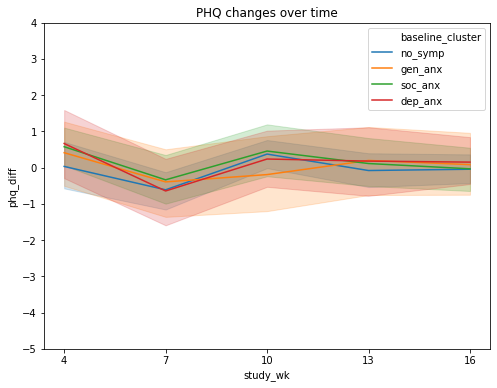

In [177]:
_, ax = plt.subplots(figsize=(8,6))
phq_corr['phq_start'] = pd.to_datetime(phq_corr['phq_start'])
g = sns.lineplot(x="study_wk", y="phq_diff", 
                 hue="baseline_cluster", 
                 hue_order=['no_symp',  'gen_anx', 'soc_anx','dep_anx'],
                            data=phq_corr, ax=ax)
plt.xticks([4, 7,10,13,16])
plt.ylim(-5,4)
plt.legend(loc="upper right")
plt.title("PHQ changes over time")
plt.show()

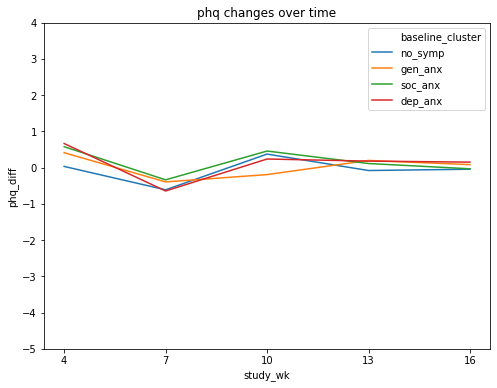

In [178]:
_, ax = plt.subplots(figsize=(8,6))
phq_corr['phq_start'] = pd.to_datetime(phq_corr['phq_start'])
g = sns.lineplot(x="study_wk", y="phq_diff", 
                 hue="baseline_cluster", 
                 hue_order=['no_symp',  'gen_anx', 'soc_anx','dep_anx'],
                 data=phq_corr, ax=ax,
                 ci=None)
plt.xticks([4,7,10,13,16])
plt.ylim(-5,4)
plt.legend(loc="upper right")
plt.title("phq changes over time")
plt.show()

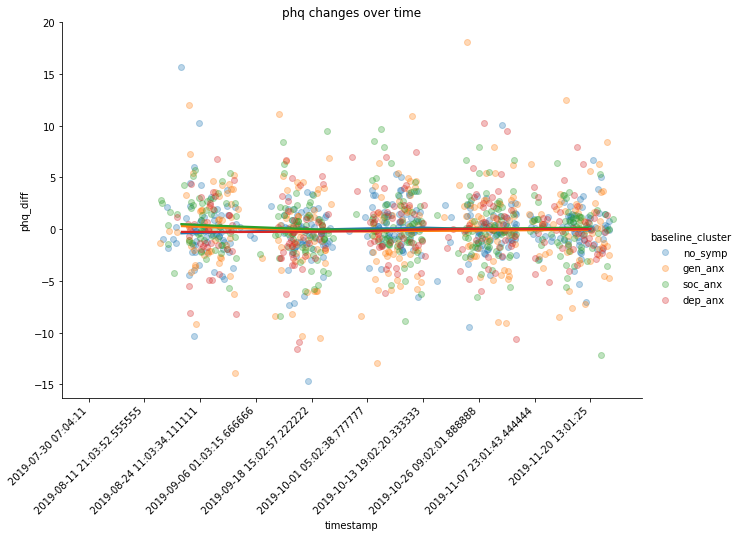

In [179]:
import matplotlib.dates as md

phq_corr['timestamp'] = (phq_corr['phq_start'] - dt.datetime(1970,1,1)).dt.total_seconds()


sns.lmplot(x='timestamp', y='phq_diff', 
           data=phq_corr, 
           lowess=True, 
           hue="baseline_cluster", 
           hue_order=['no_symp',  'gen_anx', 'soc_anx','dep_anx'],
           x_jitter=500000, y_jitter=0.5,
           scatter_kws = {
               'alpha': 0.3
           },
           height=6,
           aspect=1.5
          )
ax=plt.gca()
ticks = np.linspace(phq_corr['timestamp'].min(), phq_corr['timestamp'].max(), 10)
idx = pd.date_range(phq_corr['phq_start'].min(), phq_corr['phq_start'].max(), 10).to_pydatetime()
plt.xticks(ticks, idx, rotation=45, ha='right')
#xfmt = md.DateFormatter('%Y-%m-%d')
#ax.xaxis.set_major_formatter(xfmt)
plt.title("phq changes over time")
plt.show()

In [180]:
train_cluster = pd.read_pickle("~/lifesense/ls_data/train_cluster.df").to_frame()
test_cluster = pd.read_pickle("~/lifesense/ls_data/test_cluster.df").to_frame()
cluster_df = train_cluster.append(test_cluster)
cluster_df = cluster_df.reset_index()

cluster_df['cluster'] = cluster_df['cluster'].map({
    0: 'no_symp',
    1: 'soc_anx',
    2: 'gen_anx',
    3: 'dep_anx'
})

cluster_dict = {k:v for k, v in zip(cluster_df['pid'].values, cluster_df['cluster'].values)}

Text(0.5, 1.0, 'Within individual PHQ shift variance')

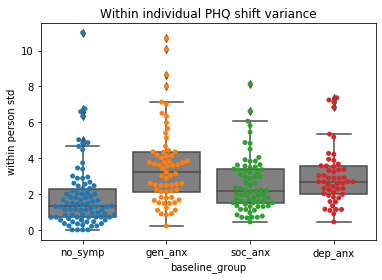

In [181]:

phq_std = phq_corr.groupby('pid')['phq_diff'].std()
phq_std = phq_std.to_frame().reset_index()
phq_std['baseline_group'] = phq_std['pid'].map(cluster_dict)
phq_std = phq_std.rename(columns={'phq_diff': 'within person std'})


ax = sns.swarmplot(x="baseline_group", y='within person std', data=phq_std,
                   #hue_order=['no_symp',  'gen_anx', 'soc_anx','dep_anx'])
                   order=['no_symp', 'gen_anx', 'soc_anx', 'dep_anx'])
ax = sns.boxplot(x="baseline_group", y='within person std', data=phq_std, 
                 #hue_order=['no_symp',  'gen_anx', 'soc_anx','dep_anx'],
                 order=['no_symp', 'gen_anx', 'soc_anx', 'dep_anx'], 
                 color=".5")
plt.title("Within individual PHQ shift variance")

In [182]:
phq_std.describe()

,within person std
count,272.000000
mean,2.658047
std,1.904565
min,0.000000
25%,1.303840
50%,2.236068
75%,3.563706
max,11.000000


In [183]:
phq_std.groupby('baseline_group').describe()

within person std                                          \
                           count      mean       std       min       25%   
baseline_group                                                             
dep_anx                     51.0  2.993774  1.597988  0.447214  1.999905   
gen_anx                     65.0  3.547788  2.176730  0.223607  2.121320   
no_symp                     86.0  1.847536  1.798082  0.000000  0.707107   
soc_anx                     70.0  2.583030  1.537872  0.447214  1.516575   

                                               
                     50%       75%        max  
baseline_group                                 
dep_anx         2.687419  3.549620   7.368853  
gen_anx         3.213254  4.335897  10.677078  
no_symp         1.322741  2.306240  11.000000  
soc_anx         2.190890  3.386217   8.136338

### SPIN

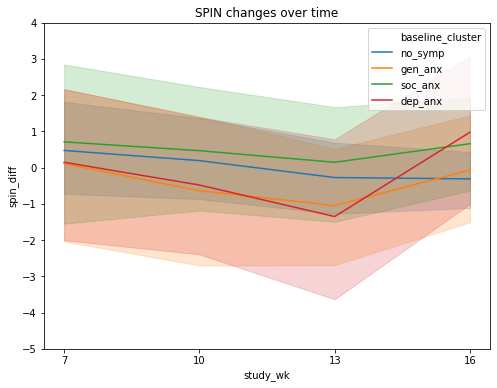

In [184]:
_, ax = plt.subplots(figsize=(8,6))
gad_spin_corr['spin_start'] = pd.to_datetime(gad_spin_corr['spin_start'])
g = sns.lineplot(x="study_wk", y="spin_diff", 
                 hue="baseline_cluster", 
                 hue_order=['no_symp',  'gen_anx', 'soc_anx','dep_anx'],
                            data=gad_spin_corr, ax=ax)
plt.xticks([7,10,13,16])
plt.ylim(-5,4)
plt.legend(loc="upper right")
plt.title("SPIN changes over time")
plt.show()

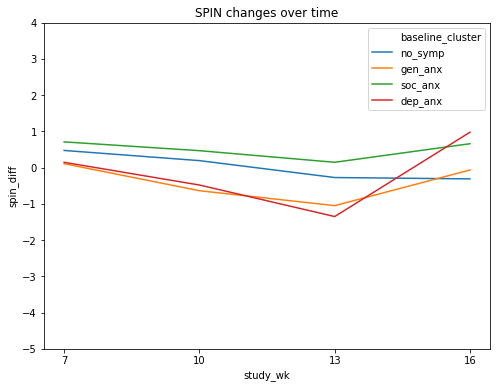

In [185]:
_, ax = plt.subplots(figsize=(8,6))
gad_spin_corr['spin_start'] = pd.to_datetime(gad_spin_corr['spin_start'])
g = sns.lineplot(x="study_wk", y="spin_diff", 
                 hue="baseline_cluster", 
                 hue_order=['no_symp',  'gen_anx', 'soc_anx','dep_anx'],
                 data=gad_spin_corr, ax=ax,
                 ci=None)
plt.xticks([7,10,13,16])
plt.ylim(-5,4)
plt.legend(loc="upper right")
plt.title("SPIN changes over time")
plt.show()

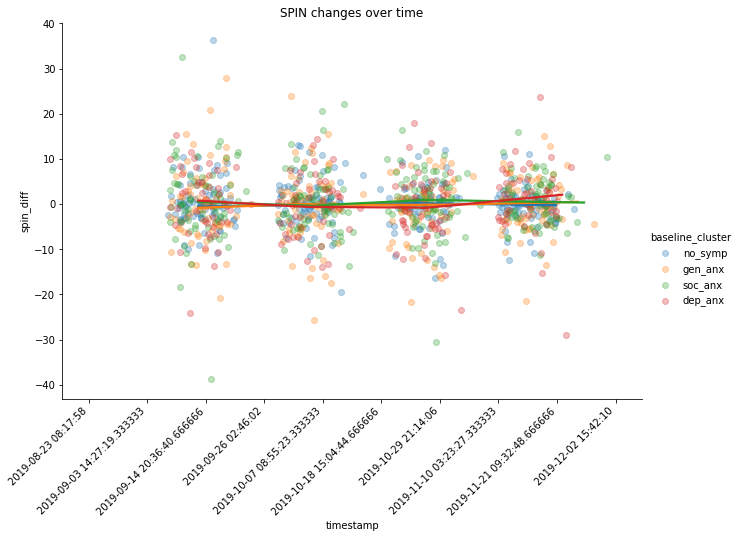

In [186]:
import matplotlib.dates as md

gad_spin_corr['timestamp'] = (gad_spin_corr['spin_start'] - dt.datetime(1970,1,1)).dt.total_seconds()

sns.lmplot(x='timestamp', y='spin_diff', 
           data=gad_spin_corr, 
           lowess=True, 
           hue="baseline_cluster", 
           hue_order=['no_symp',  'gen_anx', 'soc_anx','dep_anx'],
           x_jitter=500000, y_jitter=0.5,
           scatter_kws = {
               'alpha': 0.3
           },
           height=6,
           aspect=1.5
          )
ax=plt.gca()
ticks = np.linspace(gad_spin_corr['timestamp'].min(), gad_spin_corr['timestamp'].max(), 10)
idx = pd.date_range(gad_spin_corr['spin_start'].min(), gad_spin_corr['spin_start'].max(), 10).to_pydatetime()
plt.xticks(ticks, idx, rotation=45, ha='right')
#xfmt = md.DateFormatter('%Y-%m-%d')
#ax.xaxis.set_major_formatter(xfmt)
plt.title("SPIN changes over time")
plt.show()

Text(0.5, 1.0, 'Within individual SPIN shift variance')

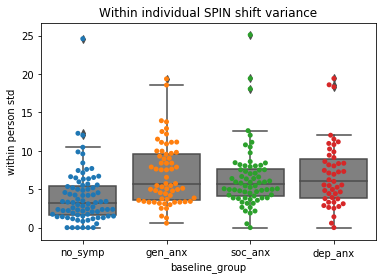

In [187]:

spin_std = gad_spin_corr.groupby('pid')['spin_diff'].std()
spin_std = spin_std.to_frame().reset_index()
spin_std['baseline_group'] = spin_std['pid'].map(cluster_dict)
spin_std = spin_std.rename(columns={'spin_diff': 'within person std'})


ax = sns.swarmplot(x="baseline_group", y='within person std', data=spin_std,
                   #hue_order=['no_symp',  'gen_anx', 'soc_anx','dep_anx'])
                   order=['no_symp', 'gen_anx', 'soc_anx', 'dep_anx'])
ax = sns.boxplot(x="baseline_group", y='within person std', data=spin_std, 
                 #hue_order=['no_symp',  'gen_anx', 'soc_anx','dep_anx'],
                 order=['no_symp', 'gen_anx', 'soc_anx', 'dep_anx'], 
                 color=".5")
plt.title("Within individual SPIN shift variance")

In [188]:
spin_std.describe()

,within person std
count,259.000000
mean,5.899790
std,4.163573
min,0.000000
25%,3.214132
50%,4.991660
75%,7.892507
max,25.118055


In [189]:
spin_std.groupby('baseline_group').describe()

within person std                                         \
                           count      mean       std      min       25%   
baseline_group                                                            
dep_anx                     46.0  6.969471  4.364506  0.00000  3.810133   
gen_anx                     63.0  6.981505  4.027708  0.57735  3.622292   
no_symp                     82.0  4.024435  3.620225  0.00000  1.657758   
soc_anx                     68.0  6.435462  4.077029  0.00000  4.052987   

                                               
                     50%       75%        max  
baseline_group                                 
dep_anx         6.129560  9.000743  19.433648  
gen_anx         5.737305  9.617501  19.379972  
no_symp         3.265986  5.469209  24.608603  
soc_anx         5.624505  7.642549  25.118055

### GAD

In [190]:
gad_spin_corr['gad_diff'] = gad_spin_corr['gad_diff'].astype(float)

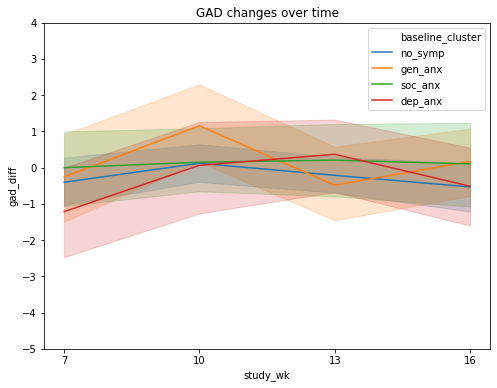

In [191]:
_, ax = plt.subplots(figsize=(8,6))
gad_spin_corr['gad_start'] = pd.to_datetime(gad_spin_corr['gad_start'])
g = sns.lineplot(x="study_wk", y="gad_diff", 
                 hue="baseline_cluster", 
                 hue_order=['no_symp',  'gen_anx', 'soc_anx','dep_anx'],
                            data=gad_spin_corr, ax=ax)
plt.xticks([7,10,13,16])
plt.ylim(-5,4)
plt.legend(loc="upper right")
plt.title("GAD changes over time")
plt.show()

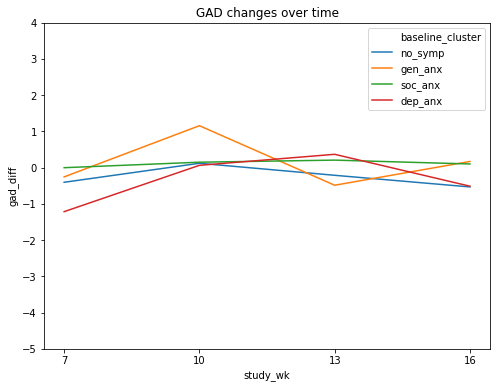

In [192]:
_, ax = plt.subplots(figsize=(8,6))
gad_spin_corr['gad_start'] = pd.to_datetime(gad_spin_corr['gad_start'])
g = sns.lineplot(x="study_wk", y="gad_diff", 
                 hue="baseline_cluster", 
                 hue_order=['no_symp',  'gen_anx', 'soc_anx','dep_anx'],
                 data=gad_spin_corr, ax=ax,
                 ci=None)
plt.xticks([7,10,13,16])
plt.ylim(-5,4)
plt.legend(loc="upper right")
plt.title("GAD changes over time")
plt.show()

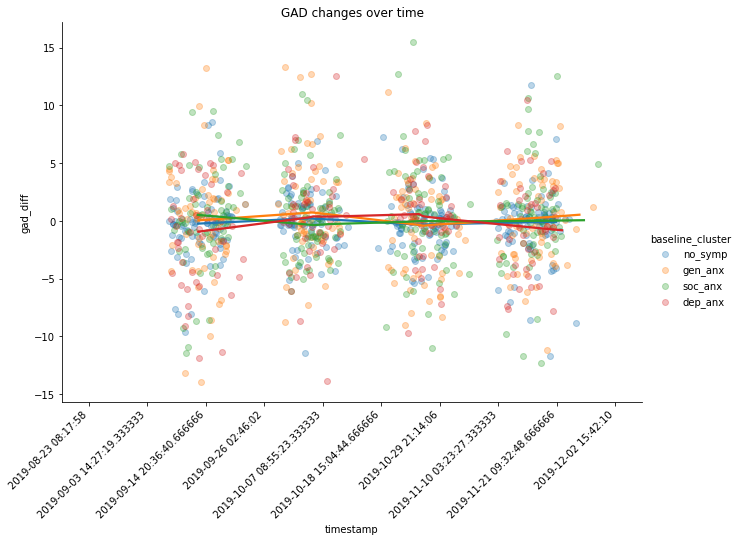

In [193]:
import matplotlib.dates as md

gad_spin_corr['timestamp'] = (gad_spin_corr['gad_start'] - dt.datetime(1970,1,1)).dt.total_seconds()

sns.lmplot(x='timestamp', y='gad_diff', 
           data=gad_spin_corr, 
           lowess=True, 
           hue="baseline_cluster", 
           hue_order=['no_symp',  'gen_anx', 'soc_anx','dep_anx'],
           x_jitter=500000, y_jitter=0.5,
           scatter_kws = {
               'alpha': 0.3
           },
           height=6,
           aspect=1.5
          )
ax=plt.gca()
ticks = np.linspace(gad_spin_corr['timestamp'].min(), gad_spin_corr['timestamp'].max(), 10)
idx = pd.date_range(gad_spin_corr['spin_start'].min(), gad_spin_corr['spin_start'].max(), 10).to_pydatetime()
plt.xticks(ticks, idx, rotation=45, ha='right')
#xfmt = md.DateFormatter('%Y-%m-%d')
#ax.xaxis.set_major_formatter(xfmt)
plt.title("GAD changes over time")
plt.show()

Text(0.5, 1.0, 'Within individual gad shift variance')

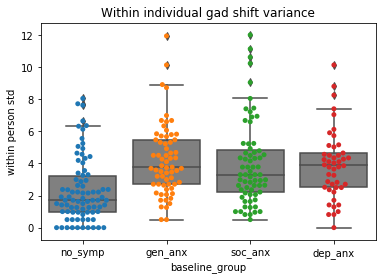

In [194]:

gad_std = gad_spin_corr.groupby('pid')['gad_diff'].std()
gad_std = gad_std.to_frame().reset_index()
gad_std['baseline_group'] = gad_std['pid'].map(cluster_dict)
gad_std = gad_std.rename(columns={'gad_diff': 'within person std'})


ax = sns.swarmplot(x="baseline_group", y='within person std', data=gad_std,
                   #hue_order=['no_symp',  'gen_anx', 'soc_anx','dep_anx'])
                   order=['no_symp', 'gen_anx', 'soc_anx', 'dep_anx'])
ax = sns.boxplot(x="baseline_group", y='within person std', data=gad_std, 
                 #hue_order=['no_symp',  'gen_anx', 'soc_anx','dep_anx'],
                 order=['no_symp', 'gen_anx', 'soc_anx', 'dep_anx'], 
                 color=".5")
plt.title("Within individual gad shift variance")

In [195]:
gad_std.describe()

,within person std
count,260.000000
mean,3.501206
std,2.382952
min,0.000000
25%,1.707825
50%,3.054563
75%,4.654747
max,12.020815


In [196]:
gad_std.groupby('baseline_group').describe()

within person std                                               \
                           count      mean       std  min       25%       50%   
baseline_group                                                                  
dep_anx                     46.0  3.907512  2.145929  0.0  2.504153  3.888995   
gen_anx                     64.0  4.192597  2.211141  0.5  2.708013  3.758287   
no_symp                     82.0  2.328305  1.999417  0.0  0.968070  1.707825   
soc_anx                     68.0  3.990012  2.632820  0.5  2.203079  3.304038   

                                     
                     75%        max  
baseline_group                       
dep_anx         4.634429  10.144785  
gen_anx         5.477226  11.954776  
no_symp         3.199490   8.057088  
soc_anx         4.830094  12.020815

# SPIN

## Full population

In [197]:
ls_utils.display_all_corr(gad_spin_corr, agg_cols_change, 'spin_diff', method='pearson')
ls_utils.display_all_corr(gad_spin_corr, agg_cols_change, 'spin_diff', method='spearman');

,X,Y,n,r,p-unc,p-corr,p-adjust
0,active_apps_agg_change,spin_diff,1028,0.017950,0.5654,0.8505,fdr_bh
1,passive_apps_agg_change,spin_diff,1028,0.043183,0.1665,0.6244,fdr_bh
2,social_apps_agg_change,spin_diff,1028,-0.003883,0.9010,0.9654,fdr_bh
3,work_dur_agg_change,spin_diff,1023,-0.000845,0.9785,0.9785,fdr_bh
4,home_dur_agg_change,spin_diff,1023,0.017919,0.5670,0.8505,fdr_bh
5,religion_dur_agg_change,spin_diff,1023,0.025267,0.4195,0.7866,fdr_bh
6,exercise_dur_agg_change,spin_diff,1023,-0.012825,0.6820,0.9300,fdr_bh
7,shopping_dur_agg_change,spin_diff,1023,-0.033042,0.2910,0.6714,fdr_bh
8,other_dur_agg_change,spin_diff,1023,0.032027,0.3061,0.6714,fdr_bh
9,social_dur_agg_change,spin_diff,1023,-0.076445,0.0145*,0.2169,fdr_bh


,X,Y,n,r,p-unc,p-corr,p-adjust
0,active_apps_agg_change,spin_diff,1028,0.008609,0.7828,0.8659,fdr_bh
1,passive_apps_agg_change,spin_diff,1028,0.078344,0.0120*,0.1340,fdr_bh
2,social_apps_agg_change,spin_diff,1028,0.017275,0.5801,0.7910,fdr_bh
3,work_dur_agg_change,spin_diff,1023,-0.021116,0.4999,0.7910,fdr_bh
4,home_dur_agg_change,spin_diff,1023,0.010250,0.7433,0.8659,fdr_bh
5,religion_dur_agg_change,spin_diff,1023,0.007601,0.8081,0.8659,fdr_bh
6,exercise_dur_agg_change,spin_diff,1023,0.033400,0.2859,0.7146,fdr_bh
7,shopping_dur_agg_change,spin_diff,1023,0.028903,0.3557,0.7623,fdr_bh
8,other_dur_agg_change,spin_diff,1023,0.017780,0.5700,0.7910,fdr_bh
9,social_dur_agg_change,spin_diff,1023,-0.051986,0.0965*,0.3620,fdr_bh


## no_symp

In [198]:
sel_state_df = gad_spin_corr[gad_spin_corr['baseline_cluster'] == 'no_symp']
ls_utils.display_all_corr(sel_state_df, agg_cols_change, 'spin_diff', method='pearson')
ls_utils.display_all_corr(sel_state_df, agg_cols_change, 'spin_diff', method='spearman');

,X,Y,n,r,p-unc,p-corr,p-adjust
0,active_apps_agg_change,spin_diff,325,0.035296,0.5260,0.9641,fdr_bh
1,passive_apps_agg_change,spin_diff,325,0.040155,0.4707,0.9641,fdr_bh
2,social_apps_agg_change,spin_diff,325,0.007009,0.8998,0.9641,fdr_bh
3,work_dur_agg_change,spin_diff,325,-0.049632,0.3725,0.9312,fdr_bh
4,home_dur_agg_change,spin_diff,325,0.002407,0.9655,0.9655,fdr_bh
5,religion_dur_agg_change,spin_diff,325,0.012323,0.8249,0.9641,fdr_bh
6,exercise_dur_agg_change,spin_diff,325,0.010818,0.8460,0.9641,fdr_bh
7,shopping_dur_agg_change,spin_diff,325,-0.083932,0.1311,0.8897,fdr_bh
8,other_dur_agg_change,spin_diff,325,0.071491,0.1986,0.8897,fdr_bh
9,social_dur_agg_change,spin_diff,325,-0.065742,0.2373,0.8897,fdr_bh


,X,Y,n,r,p-unc,p-corr,p-adjust
0,active_apps_agg_change,spin_diff,325,0.069185,0.2135,0.5415,fdr_bh
1,passive_apps_agg_change,spin_diff,325,0.083974,0.1309,0.5415,fdr_bh
2,social_apps_agg_change,spin_diff,325,0.063631,0.2527,0.5415,fdr_bh
3,work_dur_agg_change,spin_diff,325,-0.065112,0.2418,0.5415,fdr_bh
4,home_dur_agg_change,spin_diff,325,0.051002,0.3594,0.5724,fdr_bh
5,religion_dur_agg_change,spin_diff,325,-0.065012,0.2425,0.5415,fdr_bh
6,exercise_dur_agg_change,spin_diff,325,0.047442,0.3940,0.5724,fdr_bh
7,shopping_dur_agg_change,spin_diff,325,0.013767,0.8047,0.8047,fdr_bh
8,other_dur_agg_change,spin_diff,325,0.041319,0.4579,0.5724,fdr_bh
9,social_dur_agg_change,spin_diff,325,-0.083352,0.1338,0.5415,fdr_bh


## soc_anx

In [199]:
sel_state_df = gad_spin_corr[gad_spin_corr['baseline_cluster'] == 'soc_anx']
ls_utils.display_all_corr(sel_state_df, agg_cols_change, 'spin_diff', method='pearson')
ls_utils.display_all_corr(sel_state_df, agg_cols_change, 'spin_diff', method='spearman');

,X,Y,n,r,p-unc,p-corr,p-adjust
0,active_apps_agg_change,spin_diff,267,0.056254,0.3599,0.6748,fdr_bh
1,passive_apps_agg_change,spin_diff,267,0.038612,0.5299,0.7225,fdr_bh
2,social_apps_agg_change,spin_diff,267,0.027694,0.6524,0.7527,fdr_bh
3,work_dur_agg_change,spin_diff,267,0.032060,0.6020,0.7525,fdr_bh
4,home_dur_agg_change,spin_diff,267,0.057991,0.3452,0.6748,fdr_bh
5,religion_dur_agg_change,spin_diff,267,0.129742,0.0341*,0.2557,fdr_bh
6,exercise_dur_agg_change,spin_diff,267,-0.064055,0.2970,0.6748,fdr_bh
7,shopping_dur_agg_change,spin_diff,267,-0.110603,0.0712*,0.2669,fdr_bh
8,other_dur_agg_change,spin_diff,267,0.013736,0.8232,0.8232,fdr_bh
9,social_dur_agg_change,spin_diff,267,-0.116096,0.0582*,0.2669,fdr_bh


,X,Y,n,r,p-unc,p-corr,p-adjust
0,active_apps_agg_change,spin_diff,267,0.030438,0.6205,0.7160,fdr_bh
1,passive_apps_agg_change,spin_diff,267,0.143397,0.0191*,0.2860,fdr_bh
2,social_apps_agg_change,spin_diff,267,0.059734,0.3309,0.6578,fdr_bh
3,work_dur_agg_change,spin_diff,267,0.012482,0.8391,0.8991,fdr_bh
4,home_dur_agg_change,spin_diff,267,0.077627,0.2061,0.5589,fdr_bh
5,religion_dur_agg_change,spin_diff,267,0.075614,0.2181,0.5589,fdr_bh
6,exercise_dur_agg_change,spin_diff,267,0.078461,0.2012,0.5589,fdr_bh
7,shopping_dur_agg_change,spin_diff,267,0.035119,0.5678,0.7160,fdr_bh
8,other_dur_agg_change,spin_diff,267,0.074735,0.2235,0.5589,fdr_bh
9,social_dur_agg_change,spin_diff,267,-0.094788,0.1223,0.5589,fdr_bh


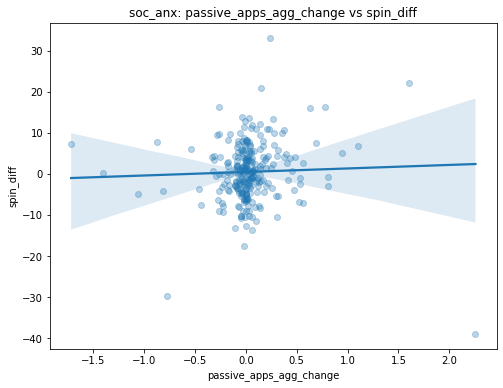

In [200]:
ls_utils.plot_cluster_scatter('passive_apps_agg_change', 'spin_diff', sel_state_df, 'soc_anx', (8,6))

## gen_anx

In [201]:
sel_state_df = gad_spin_corr[gad_spin_corr['baseline_cluster'] == 'gen_anx']
ls_utils.display_all_corr(sel_state_df, agg_cols_change, 'spin_diff', method='pearson')
ls_utils.display_all_corr(sel_state_df, agg_cols_change, 'spin_diff', method='spearman');

,X,Y,n,r,p-unc,p-corr,p-adjust
0,active_apps_agg_change,spin_diff,252,-0.068702,0.2773,0.6726,fdr_bh
1,passive_apps_agg_change,spin_diff,252,0.006098,0.9233,0.9233,fdr_bh
2,social_apps_agg_change,spin_diff,252,-0.047964,0.4484,0.6726,fdr_bh
3,work_dur_agg_change,spin_diff,251,-0.023126,0.7154,0.8255,fdr_bh
4,home_dur_agg_change,spin_diff,251,-0.054944,0.3861,0.6726,fdr_bh
5,religion_dur_agg_change,spin_diff,251,0.029567,0.6411,0.8014,fdr_bh
6,exercise_dur_agg_change,spin_diff,251,0.049004,0.4395,0.6726,fdr_bh
7,shopping_dur_agg_change,spin_diff,251,0.102895,0.1039,0.5194,fdr_bh
8,other_dur_agg_change,spin_diff,251,0.040453,0.5235,0.7139,fdr_bh
9,social_dur_agg_change,spin_diff,251,-0.070775,0.2640,0.6726,fdr_bh


,X,Y,n,r,p-unc,p-corr,p-adjust
0,active_apps_agg_change,spin_diff,252,-0.067907,0.2829,0.5637,fdr_bh
1,passive_apps_agg_change,spin_diff,252,0.053506,0.3977,0.5637,fdr_bh
2,social_apps_agg_change,spin_diff,252,-0.039570,0.5318,0.6340,fdr_bh
3,work_dur_agg_change,spin_diff,251,-0.065343,0.3025,0.5637,fdr_bh
4,home_dur_agg_change,spin_diff,251,-0.073573,0.2455,0.5637,fdr_bh
5,religion_dur_agg_change,spin_diff,251,0.079253,0.2108,0.5637,fdr_bh
6,exercise_dur_agg_change,spin_diff,251,0.037953,0.5495,0.6340,fdr_bh
7,shopping_dur_agg_change,spin_diff,251,0.090487,0.1529,0.5637,fdr_bh
8,other_dur_agg_change,spin_diff,251,-0.051850,0.4134,0.5637,fdr_bh
9,social_dur_agg_change,spin_diff,251,-0.031130,0.6235,0.6633,fdr_bh


## dep_anx

In [202]:
sel_state_df = gad_spin_corr[gad_spin_corr['baseline_cluster'] == 'dep_anx']
ls_utils.display_all_corr(sel_state_df, agg_cols_change, 'spin_diff', method='pearson')
ls_utils.display_all_corr(sel_state_df, agg_cols_change, 'spin_diff', method='spearman');

,X,Y,n,r,p-unc,p-corr,p-adjust
0,active_apps_agg_change,spin_diff,184,0.044064,0.5526,0.9519,fdr_bh
1,passive_apps_agg_change,spin_diff,184,0.137741,0.0622*,0.9336,fdr_bh
2,social_apps_agg_change,spin_diff,184,-0.002066,0.9778,0.9827,fdr_bh
3,work_dur_agg_change,spin_diff,180,-0.004128,0.9561,0.9827,fdr_bh
4,home_dur_agg_change,spin_diff,180,0.073762,0.3251,0.9519,fdr_bh
5,religion_dur_agg_change,spin_diff,180,-0.083094,0.2674,0.9519,fdr_bh
6,exercise_dur_agg_change,spin_diff,180,-0.080906,0.2803,0.9519,fdr_bh
7,shopping_dur_agg_change,spin_diff,180,-0.001624,0.9827,0.9827,fdr_bh
8,other_dur_agg_change,spin_diff,180,-0.010092,0.8930,0.9827,fdr_bh
9,social_dur_agg_change,spin_diff,180,-0.044537,0.5527,0.9519,fdr_bh


,X,Y,n,r,p-unc,p-corr,p-adjust
0,active_apps_agg_change,spin_diff,184,-0.018474,0.8034,0.9132,fdr_bh
1,passive_apps_agg_change,spin_diff,184,0.031941,0.6669,0.9132,fdr_bh
2,social_apps_agg_change,spin_diff,184,-0.018864,0.7994,0.9132,fdr_bh
3,work_dur_agg_change,spin_diff,180,0.045496,0.5442,0.9132,fdr_bh
4,home_dur_agg_change,spin_diff,180,-0.008177,0.9132,0.9132,fdr_bh
5,religion_dur_agg_change,spin_diff,180,-0.071122,0.3427,0.9132,fdr_bh
6,exercise_dur_agg_change,spin_diff,180,-0.094531,0.2069,0.9132,fdr_bh
7,shopping_dur_agg_change,spin_diff,180,-0.045580,0.5435,0.9132,fdr_bh
8,other_dur_agg_change,spin_diff,180,-0.011118,0.8822,0.9132,fdr_bh
9,social_dur_agg_change,spin_diff,180,0.009299,0.9014,0.9132,fdr_bh


# Reverse SPIN

## Full population

In [203]:
ls_utils.display_all_corr(rev_gad_spin_corr, agg_cols_change, 'spin_diff', method='pearson')
ls_utils.display_all_corr(rev_gad_spin_corr, agg_cols_change, 'spin_diff', method='spearman');

,X,Y,n,r,p-unc,p-corr,p-adjust
0,active_apps_agg_change,spin_diff,1023,0.037207,0.2344,0.5133,fdr_bh
1,passive_apps_agg_change,spin_diff,1023,-0.008104,0.7957,0.9149,fdr_bh
2,social_apps_agg_change,spin_diff,1023,0.024923,0.4259,0.7098,fdr_bh
3,work_dur_agg_change,spin_diff,1020,0.009137,0.7707,0.9149,fdr_bh
4,home_dur_agg_change,spin_diff,1020,0.032835,0.2948,0.5527,fdr_bh
5,religion_dur_agg_change,spin_diff,1020,0.051939,0.0973*,0.3650,fdr_bh
6,exercise_dur_agg_change,spin_diff,1020,-0.059347,0.0581*,0.3650,fdr_bh
7,shopping_dur_agg_change,spin_diff,1020,0.012507,0.6899,0.9149,fdr_bh
8,other_dur_agg_change,spin_diff,1020,0.003352,0.9149,0.9149,fdr_bh
9,social_dur_agg_change,spin_diff,1020,0.045659,0.1451,0.4352,fdr_bh


,X,Y,n,r,p-unc,p-corr,p-adjust
0,active_apps_agg_change,spin_diff,1023,0.024448,0.4347,0.7245,fdr_bh
1,passive_apps_agg_change,spin_diff,1023,0.007008,0.8229,0.9211,fdr_bh
2,social_apps_agg_change,spin_diff,1023,0.045627,0.1448,0.7238,fdr_bh
3,work_dur_agg_change,spin_diff,1020,0.029306,0.3498,0.7245,fdr_bh
4,home_dur_agg_change,spin_diff,1020,0.032895,0.2939,0.7245,fdr_bh
5,religion_dur_agg_change,spin_diff,1020,0.019031,0.5438,0.7793,fdr_bh
6,exercise_dur_agg_change,spin_diff,1020,-0.017739,0.5715,0.7793,fdr_bh
7,shopping_dur_agg_change,spin_diff,1020,-0.003932,0.9002,0.9211,fdr_bh
8,other_dur_agg_change,spin_diff,1020,0.059269,0.0585*,0.4384,fdr_bh
9,social_dur_agg_change,spin_diff,1020,0.036288,0.2469,0.7245,fdr_bh


## no_symp

In [204]:
rev_sel_state_df = rev_gad_spin_corr[rev_gad_spin_corr['baseline_cluster'] == 'no_symp']
ls_utils.display_all_corr(rev_sel_state_df, agg_cols_change, 'spin_diff', method='pearson')
ls_utils.display_all_corr(rev_sel_state_df, agg_cols_change, 'spin_diff', method='spearman');

,X,Y,n,r,p-unc,p-corr,p-adjust
0,active_apps_agg_change,spin_diff,325,0.005830,0.9166,0.9606,fdr_bh
1,passive_apps_agg_change,spin_diff,325,0.027856,0.6168,0.8340,fdr_bh
2,social_apps_agg_change,spin_diff,325,0.025896,0.6418,0.8340,fdr_bh
3,work_dur_agg_change,spin_diff,325,0.058455,0.2934,0.6704,fdr_bh
4,home_dur_agg_change,spin_diff,325,0.002753,0.9606,0.9606,fdr_bh
5,religion_dur_agg_change,spin_diff,325,0.051674,0.3531,0.6704,fdr_bh
6,exercise_dur_agg_change,spin_diff,325,-0.070844,0.2027,0.6704,fdr_bh
7,shopping_dur_agg_change,spin_diff,325,0.129947,0.0191*,0.2865,fdr_bh
8,other_dur_agg_change,spin_diff,325,0.023939,0.6672,0.8340,fdr_bh
9,social_dur_agg_change,spin_diff,325,0.088484,0.1114,0.6704,fdr_bh


,X,Y,n,r,p-unc,p-corr,p-adjust
0,active_apps_agg_change,spin_diff,325,-0.013959,0.8021,0.8899,fdr_bh
1,passive_apps_agg_change,spin_diff,325,0.016035,0.7734,0.8899,fdr_bh
2,social_apps_agg_change,spin_diff,325,0.089856,0.1059,0.7478,fdr_bh
3,work_dur_agg_change,spin_diff,325,0.026670,0.6319,0.8899,fdr_bh
4,home_dur_agg_change,spin_diff,325,0.011913,0.8306,0.8899,fdr_bh
5,religion_dur_agg_change,spin_diff,325,0.057305,0.3030,0.8899,fdr_bh
6,exercise_dur_agg_change,spin_diff,325,-0.002911,0.9583,0.9583,fdr_bh
7,shopping_dur_agg_change,spin_diff,325,0.034284,0.5380,0.8899,fdr_bh
8,other_dur_agg_change,spin_diff,325,0.028185,0.6127,0.8899,fdr_bh
9,social_dur_agg_change,spin_diff,325,0.089992,0.1054,0.7478,fdr_bh


## soc_anx

In [205]:
rev_sel_state_df = rev_gad_spin_corr[rev_gad_spin_corr['baseline_cluster'] == 'soc_anx']
ls_utils.display_all_corr(rev_sel_state_df, agg_cols_change, 'spin_diff', method='pearson')
ls_utils.display_all_corr(rev_sel_state_df, agg_cols_change, 'spin_diff', method='spearman');

,X,Y,n,r,p-unc,p-corr,p-adjust
0,active_apps_agg_change,spin_diff,266,0.047486,0.4405,0.7717,fdr_bh
1,passive_apps_agg_change,spin_diff,266,-0.126167,0.0398*,0.2982,fdr_bh
2,social_apps_agg_change,spin_diff,266,-0.035354,0.5659,0.7717,fdr_bh
3,work_dur_agg_change,spin_diff,266,-0.076558,0.2133,0.6399,fdr_bh
4,home_dur_agg_change,spin_diff,266,0.016362,0.7905,0.8802,fdr_bh
5,religion_dur_agg_change,spin_diff,266,0.155007,0.0114*,0.1704,fdr_bh
6,exercise_dur_agg_change,spin_diff,266,-0.087296,0.1557,0.5838,fdr_bh
7,shopping_dur_agg_change,spin_diff,266,0.007645,0.9012,0.9012,fdr_bh
8,other_dur_agg_change,spin_diff,266,0.037068,0.5472,0.7717,fdr_bh
9,social_dur_agg_change,spin_diff,266,0.047749,0.4380,0.7717,fdr_bh


,X,Y,n,r,p-unc,p-corr,p-adjust
0,active_apps_agg_change,spin_diff,266,0.044430,0.4706,0.8347,fdr_bh
1,passive_apps_agg_change,spin_diff,266,-0.046378,0.4513,0.8347,fdr_bh
2,social_apps_agg_change,spin_diff,266,-0.014721,0.8111,0.9952,fdr_bh
3,work_dur_agg_change,spin_diff,266,-0.044385,0.4710,0.8347,fdr_bh
4,home_dur_agg_change,spin_diff,266,-0.003634,0.9530,0.9952,fdr_bh
5,religion_dur_agg_change,spin_diff,266,0.059819,0.3311,0.8347,fdr_bh
6,exercise_dur_agg_change,spin_diff,266,0.001323,0.9829,0.9952,fdr_bh
7,shopping_dur_agg_change,spin_diff,266,0.008827,0.8861,0.9952,fdr_bh
8,other_dur_agg_change,spin_diff,266,0.180693,0.0031*,0.0465*,fdr_bh
9,social_dur_agg_change,spin_diff,266,0.023584,0.7018,0.9952,fdr_bh


## gen_anx

In [206]:
rev_sel_state_df = rev_gad_spin_corr[rev_gad_spin_corr['baseline_cluster'] == 'gen_anx']
ls_utils.display_all_corr(rev_sel_state_df, agg_cols_change, 'spin_diff', method='pearson')
ls_utils.display_all_corr(rev_sel_state_df, agg_cols_change, 'spin_diff', method='spearman');

,X,Y,n,r,p-unc,p-corr,p-adjust
0,active_apps_agg_change,spin_diff,251,0.083871,0.1853,0.6950,fdr_bh
1,passive_apps_agg_change,spin_diff,251,0.036672,0.5631,0.7014,fdr_bh
2,social_apps_agg_change,spin_diff,251,0.042943,0.4982,0.7014,fdr_bh
3,work_dur_agg_change,spin_diff,251,0.029512,0.6417,0.7014,fdr_bh
4,home_dur_agg_change,spin_diff,251,0.094182,0.1368,0.6838,fdr_bh
5,religion_dur_agg_change,spin_diff,251,-0.029519,0.6416,0.7014,fdr_bh
6,exercise_dur_agg_change,spin_diff,251,-0.073235,0.2477,0.7014,fdr_bh
7,shopping_dur_agg_change,spin_diff,251,-0.028374,0.6546,0.7014,fdr_bh
8,other_dur_agg_change,spin_diff,251,-0.035942,0.5709,0.7014,fdr_bh
9,social_dur_agg_change,spin_diff,251,-0.030008,0.6361,0.7014,fdr_bh


,X,Y,n,r,p-unc,p-corr,p-adjust
0,active_apps_agg_change,spin_diff,251,0.072293,0.2538,0.6536,fdr_bh
1,passive_apps_agg_change,spin_diff,251,0.021815,0.7309,0.7864,fdr_bh
2,social_apps_agg_change,spin_diff,251,0.048797,0.4415,0.6536,fdr_bh
3,work_dur_agg_change,spin_diff,251,0.045824,0.4698,0.6536,fdr_bh
4,home_dur_agg_change,spin_diff,251,0.085780,0.1755,0.6536,fdr_bh
5,religion_dur_agg_change,spin_diff,251,-0.057605,0.3634,0.6536,fdr_bh
6,exercise_dur_agg_change,spin_diff,251,-0.093419,0.1400,0.6536,fdr_bh
7,shopping_dur_agg_change,spin_diff,251,-0.017186,0.7864,0.7864,fdr_bh
8,other_dur_agg_change,spin_diff,251,-0.044851,0.4793,0.6536,fdr_bh
9,social_dur_agg_change,spin_diff,251,-0.076803,0.2253,0.6536,fdr_bh


## dep_anx

In [207]:
rev_sel_state_df = rev_gad_spin_corr[rev_gad_spin_corr['baseline_cluster'] == 'dep_anx']
ls_utils.display_all_corr(rev_sel_state_df, agg_cols_change, 'spin_diff', method='pearson')
ls_utils.display_all_corr(rev_sel_state_df, agg_cols_change, 'spin_diff', method='spearman');

,X,Y,n,r,p-unc,p-corr,p-adjust
0,active_apps_agg_change,spin_diff,181,-0.010102,0.8926,0.9374,fdr_bh
1,passive_apps_agg_change,spin_diff,181,0.089206,0.2324,0.9374,fdr_bh
2,social_apps_agg_change,spin_diff,181,0.055804,0.4556,0.9374,fdr_bh
3,work_dur_agg_change,spin_diff,178,0.078100,0.3001,0.9374,fdr_bh
4,home_dur_agg_change,spin_diff,178,0.005928,0.9374,0.9374,fdr_bh
5,religion_dur_agg_change,spin_diff,178,0.035489,0.6381,0.9374,fdr_bh
6,exercise_dur_agg_change,spin_diff,178,0.024220,0.7483,0.9374,fdr_bh
7,shopping_dur_agg_change,spin_diff,178,-0.092420,0.2198,0.9374,fdr_bh
8,other_dur_agg_change,spin_diff,178,0.018519,0.8062,0.9374,fdr_bh
9,social_dur_agg_change,spin_diff,178,0.076272,0.3116,0.9374,fdr_bh


,X,Y,n,r,p-unc,p-corr,p-adjust
0,active_apps_agg_change,spin_diff,181,-0.020657,0.7825,0.8979,fdr_bh
1,passive_apps_agg_change,spin_diff,181,0.069266,0.3542,0.8854,fdr_bh
2,social_apps_agg_change,spin_diff,181,0.072566,0.3317,0.8854,fdr_bh
3,work_dur_agg_change,spin_diff,178,0.100445,0.1822,0.8854,fdr_bh
4,home_dur_agg_change,spin_diff,178,0.052674,0.4850,0.8979,fdr_bh
5,religion_dur_agg_change,spin_diff,178,-0.006819,0.9280,0.9280,fdr_bh
6,exercise_dur_agg_change,spin_diff,178,0.033135,0.6606,0.8979,fdr_bh
7,shopping_dur_agg_change,spin_diff,178,-0.042993,0.5688,0.8979,fdr_bh
8,other_dur_agg_change,spin_diff,178,0.076219,0.3119,0.8854,fdr_bh
9,social_dur_agg_change,spin_diff,178,0.117393,0.1186,0.8854,fdr_bh


# GAD

## Full population

In [208]:
ls_utils.display_all_corr(gad_spin_corr, agg_cols_change, 'gad_diff', method='pearson')
ls_utils.display_all_corr(gad_spin_corr, agg_cols_change, 'gad_diff', method='spearman');

,X,Y,n,r,p-unc,p-corr,p-adjust
0,active_apps_agg_change,gad_diff,1029,0.044037,0.1581,0.4742,fdr_bh
1,passive_apps_agg_change,gad_diff,1029,0.025532,0.4133,0.6888,fdr_bh
2,social_apps_agg_change,gad_diff,1029,-0.033448,0.2838,0.5320,fdr_bh
3,work_dur_agg_change,gad_diff,1024,0.049381,0.1143,0.4742,fdr_bh
4,home_dur_agg_change,gad_diff,1024,0.010525,0.7366,0.7366,fdr_bh
5,religion_dur_agg_change,gad_diff,1024,0.012815,0.6821,0.7366,fdr_bh
6,exercise_dur_agg_change,gad_diff,1024,0.013908,0.6567,0.7366,fdr_bh
7,shopping_dur_agg_change,gad_diff,1024,-0.033824,0.2795,0.5320,fdr_bh
8,other_dur_agg_change,gad_diff,1024,-0.044164,0.1579,0.4742,fdr_bh
9,social_dur_agg_change,gad_diff,1024,-0.034428,0.2710,0.5320,fdr_bh


,X,Y,n,r,p-unc,p-corr,p-adjust
0,active_apps_agg_change,gad_diff,1029,0.082725,0.0079*,0.0720*,fdr_bh
1,passive_apps_agg_change,gad_diff,1029,0.023170,0.4578,0.8619,fdr_bh
2,social_apps_agg_change,gad_diff,1029,-0.028440,0.3621,0.8619,fdr_bh
3,work_dur_agg_change,gad_diff,1024,0.070077,0.0249*,0.0935*,fdr_bh
4,home_dur_agg_change,gad_diff,1024,-0.002250,0.9427,0.9469,fdr_bh
5,religion_dur_agg_change,gad_diff,1024,-0.004381,0.8886,0.9469,fdr_bh
6,exercise_dur_agg_change,gad_diff,1024,0.017003,0.5868,0.8619,fdr_bh
7,shopping_dur_agg_change,gad_diff,1024,-0.004110,0.8955,0.9469,fdr_bh
8,other_dur_agg_change,gad_diff,1024,-0.014982,0.6320,0.8619,fdr_bh
9,social_dur_agg_change,gad_diff,1024,-0.022444,0.4731,0.8619,fdr_bh


## no_symp

In [209]:
sel_state_df = gad_spin_corr[gad_spin_corr['baseline_cluster'] == 'no_symp']
ls_utils.display_all_corr(sel_state_df, agg_cols_change, 'gad_diff', method='pearson')
ls_utils.display_all_corr(sel_state_df, agg_cols_change, 'gad_diff', method='spearman');

,X,Y,n,r,p-unc,p-corr,p-adjust
0,active_apps_agg_change,gad_diff,325,-0.007699,0.8900,0.8900,fdr_bh
1,passive_apps_agg_change,gad_diff,325,0.070992,0.2018,0.6517,fdr_bh
2,social_apps_agg_change,gad_diff,325,0.095487,0.0857*,0.4283,fdr_bh
3,work_dur_agg_change,gad_diff,325,0.019730,0.7231,0.7747,fdr_bh
4,home_dur_agg_change,gad_diff,325,0.118314,0.0330*,0.2791,fdr_bh
5,religion_dur_agg_change,gad_diff,325,-0.023004,0.6795,0.7747,fdr_bh
6,exercise_dur_agg_change,gad_diff,325,0.045601,0.4126,0.6517,fdr_bh
7,shopping_dur_agg_change,gad_diff,325,0.036900,0.5074,0.6919,fdr_bh
8,other_dur_agg_change,gad_diff,325,-0.060907,0.2736,0.6517,fdr_bh
9,social_dur_agg_change,gad_diff,325,-0.043499,0.4345,0.6517,fdr_bh


,X,Y,n,r,p-unc,p-corr,p-adjust
0,active_apps_agg_change,gad_diff,325,0.003022,0.9567,0.9567,fdr_bh
1,passive_apps_agg_change,gad_diff,325,0.109045,0.0495*,0.7165,fdr_bh
2,social_apps_agg_change,gad_diff,325,0.072601,0.1917,0.7165,fdr_bh
3,work_dur_agg_change,gad_diff,325,-0.022002,0.6927,0.7993,fdr_bh
4,home_dur_agg_change,gad_diff,325,0.027114,0.6262,0.7993,fdr_bh
5,religion_dur_agg_change,gad_diff,325,-0.063026,0.2572,0.7165,fdr_bh
6,exercise_dur_agg_change,gad_diff,325,0.039662,0.4761,0.7993,fdr_bh
7,shopping_dur_agg_change,gad_diff,325,-0.024530,0.6595,0.7993,fdr_bh
8,other_dur_agg_change,gad_diff,325,0.090526,0.1033,0.7165,fdr_bh
9,social_dur_agg_change,gad_diff,325,0.034966,0.5299,0.7993,fdr_bh


## soc_anx

In [210]:
sel_state_df = gad_spin_corr[gad_spin_corr['baseline_cluster'] == 'soc_anx']
ls_utils.display_all_corr(sel_state_df, agg_cols_change, 'gad_diff', method='pearson')
ls_utils.display_all_corr(sel_state_df, agg_cols_change, 'gad_diff', method='spearman');

,X,Y,n,r,p-unc,p-corr,p-adjust
0,active_apps_agg_change,gad_diff,267,0.084014,0.1711,0.9273,fdr_bh
1,passive_apps_agg_change,gad_diff,267,0.062478,0.3091,0.9273,fdr_bh
2,social_apps_agg_change,gad_diff,267,0.003281,0.9574,0.9971,fdr_bh
3,work_dur_agg_change,gad_diff,267,-0.000227,0.9971,0.9971,fdr_bh
4,home_dur_agg_change,gad_diff,267,0.029218,0.6346,0.9519,fdr_bh
5,religion_dur_agg_change,gad_diff,267,0.068335,0.2659,0.9273,fdr_bh
6,exercise_dur_agg_change,gad_diff,267,-0.047344,0.4411,0.9451,fdr_bh
7,shopping_dur_agg_change,gad_diff,267,-0.076906,0.2103,0.9273,fdr_bh
8,other_dur_agg_change,gad_diff,267,0.009350,0.8791,0.9971,fdr_bh
9,social_dur_agg_change,gad_diff,267,-0.021832,0.7225,0.9852,fdr_bh


,X,Y,n,r,p-unc,p-corr,p-adjust
0,active_apps_agg_change,gad_diff,267,0.189139,0.0019*,0.0275*,fdr_bh
1,passive_apps_agg_change,gad_diff,267,0.048509,0.4299,0.7523,fdr_bh
2,social_apps_agg_change,gad_diff,267,0.038288,0.5333,0.7523,fdr_bh
3,work_dur_agg_change,gad_diff,267,0.036586,0.5517,0.7523,fdr_bh
4,home_dur_agg_change,gad_diff,267,0.044926,0.4648,0.7523,fdr_bh
5,religion_dur_agg_change,gad_diff,267,0.082832,0.1772,0.5722,fdr_bh
6,exercise_dur_agg_change,gad_diff,267,-0.010443,0.8651,0.9242,fdr_bh
7,shopping_dur_agg_change,gad_diff,267,0.010678,0.8621,0.9242,fdr_bh
8,other_dur_agg_change,gad_diff,267,-0.013392,0.8276,0.9242,fdr_bh
9,social_dur_agg_change,gad_diff,267,-0.005849,0.9242,0.9242,fdr_bh


## gen_anx

In [211]:
sel_state_df = gad_spin_corr[gad_spin_corr['baseline_cluster'] == 'gen_anx']
ls_utils.display_all_corr(sel_state_df, agg_cols_change, 'gad_diff', method='pearson')
ls_utils.display_all_corr(sel_state_df, agg_cols_change, 'gad_diff', method='spearman');

,X,Y,n,r,p-unc,p-corr,p-adjust
0,active_apps_agg_change,gad_diff,253,0.098878,0.1167,0.6441,fdr_bh
1,passive_apps_agg_change,gad_diff,253,-0.054007,0.3923,0.6441,fdr_bh
2,social_apps_agg_change,gad_diff,253,-0.000180,0.9977,0.9977,fdr_bh
3,work_dur_agg_change,gad_diff,252,0.067958,0.2825,0.6441,fdr_bh
4,home_dur_agg_change,gad_diff,252,-0.085872,0.1742,0.6441,fdr_bh
5,religion_dur_agg_change,gad_diff,252,-0.006634,0.9165,0.9820,fdr_bh
6,exercise_dur_agg_change,gad_diff,252,0.045441,0.4727,0.6441,fdr_bh
7,shopping_dur_agg_change,gad_diff,252,-0.050404,0.4256,0.6441,fdr_bh
8,other_dur_agg_change,gad_diff,252,-0.053060,0.4016,0.6441,fdr_bh
9,social_dur_agg_change,gad_diff,252,0.042451,0.5023,0.6441,fdr_bh


,X,Y,n,r,p-unc,p-corr,p-adjust
0,active_apps_agg_change,gad_diff,253,0.137795,0.0284*,0.4264,fdr_bh
1,passive_apps_agg_change,gad_diff,253,-0.042871,0.4972,0.9169,fdr_bh
2,social_apps_agg_change,gad_diff,253,-0.010442,0.8687,0.9308,fdr_bh
3,work_dur_agg_change,gad_diff,252,0.113723,0.0715*,0.5364,fdr_bh
4,home_dur_agg_change,gad_diff,252,-0.062399,0.3238,0.9169,fdr_bh
5,religion_dur_agg_change,gad_diff,252,-0.079936,0.2060,0.7725,fdr_bh
6,exercise_dur_agg_change,gad_diff,252,0.029088,0.6458,0.9169,fdr_bh
7,shopping_dur_agg_change,gad_diff,252,-0.022156,0.7263,0.9169,fdr_bh
8,other_dur_agg_change,gad_diff,252,-0.021268,0.7369,0.9169,fdr_bh
9,social_dur_agg_change,gad_diff,252,-0.030890,0.6255,0.9169,fdr_bh


## dep_anx

In [212]:
sel_state_df = gad_spin_corr[gad_spin_corr['baseline_cluster'] == 'dep_anx']
ls_utils.display_all_corr(sel_state_df, agg_cols_change, 'gad_diff', method='pearson')
ls_utils.display_all_corr(sel_state_df, agg_cols_change, 'gad_diff', method='spearman');

,X,Y,n,r,p-unc,p-corr,p-adjust
0,active_apps_agg_change,gad_diff,184,-0.052732,0.4771,0.9253,fdr_bh
1,passive_apps_agg_change,gad_diff,184,0.005661,0.9392,0.9392,fdr_bh
2,social_apps_agg_change,gad_diff,184,-0.219640,0.0027*,0.0411*,fdr_bh
3,work_dur_agg_change,gad_diff,180,0.175808,0.0182*,0.1368,fdr_bh
4,home_dur_agg_change,gad_diff,180,-0.016548,0.8255,0.9325,fdr_bh
5,religion_dur_agg_change,gad_diff,180,0.042733,0.5690,0.9253,fdr_bh
6,exercise_dur_agg_change,gad_diff,180,0.024884,0.7402,0.9253,fdr_bh
7,shopping_dur_agg_change,gad_diff,180,0.028406,0.7050,0.9253,fdr_bh
8,other_dur_agg_change,gad_diff,180,-0.108770,0.1461,0.5479,fdr_bh
9,social_dur_agg_change,gad_diff,180,-0.146992,0.0489*,0.2447,fdr_bh


,X,Y,n,r,p-unc,p-corr,p-adjust
0,active_apps_agg_change,gad_diff,184,-0.014492,0.8452,0.9247,fdr_bh
1,passive_apps_agg_change,gad_diff,184,-0.038762,0.6014,0.8375,fdr_bh
2,social_apps_agg_change,gad_diff,184,-0.245944,0.0008*,0.0115*,fdr_bh
3,work_dur_agg_change,gad_diff,180,0.158782,0.0333*,0.2433,fdr_bh
4,home_dur_agg_change,gad_diff,180,-0.039744,0.5963,0.8375,fdr_bh
5,religion_dur_agg_change,gad_diff,180,0.049943,0.5055,0.8375,fdr_bh
6,exercise_dur_agg_change,gad_diff,180,-0.013936,0.8527,0.9247,fdr_bh
7,shopping_dur_agg_change,gad_diff,180,0.037828,0.6142,0.8375,fdr_bh
8,other_dur_agg_change,gad_diff,180,-0.138702,0.0633*,0.2433,fdr_bh
9,social_dur_agg_change,gad_diff,180,-0.137904,0.0649*,0.2433,fdr_bh


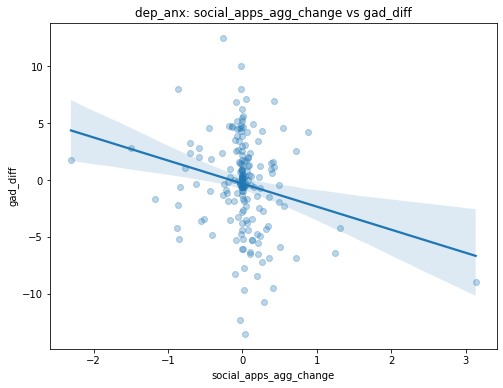

In [213]:
ls_utils.plot_cluster_scatter('social_apps_agg_change', 'gad_diff', gad_spin_corr, 'dep_anx', (8,6))

# Reverse GAD

## Full population

In [214]:
ls_utils.display_all_corr(rev_gad_spin_corr, agg_cols_change, 'gad_diff', method='pearson')
ls_utils.display_all_corr(rev_gad_spin_corr, agg_cols_change, 'gad_diff', method='spearman');

,X,Y,n,r,p-unc,p-corr,p-adjust
0,active_apps_agg_change,gad_diff,1023,0.022532,0.4716,0.6506,fdr_bh
1,passive_apps_agg_change,gad_diff,1023,-0.002767,0.9296,0.9296,fdr_bh
2,social_apps_agg_change,gad_diff,1023,0.070456,0.0242*,0.2334,fdr_bh
3,work_dur_agg_change,gad_diff,1020,-0.008499,0.7863,0.8425,fdr_bh
4,home_dur_agg_change,gad_diff,1020,-0.037850,0.2271,0.5113,fdr_bh
5,religion_dur_agg_change,gad_diff,1020,0.010199,0.7449,0.8425,fdr_bh
6,exercise_dur_agg_change,gad_diff,1020,-0.034377,0.2727,0.5113,fdr_bh
7,shopping_dur_agg_change,gad_diff,1020,-0.022285,0.4771,0.6506,fdr_bh
8,other_dur_agg_change,gad_diff,1020,0.035428,0.2583,0.5113,fdr_bh
9,social_dur_agg_change,gad_diff,1020,0.043355,0.1665,0.4994,fdr_bh


,X,Y,n,r,p-unc,p-corr,p-adjust
0,active_apps_agg_change,gad_diff,1023,0.021974,0.4827,0.6562,fdr_bh
1,passive_apps_agg_change,gad_diff,1023,-0.028920,0.3555,0.6467,fdr_bh
2,social_apps_agg_change,gad_diff,1023,0.059060,0.0590*,0.3836,fdr_bh
3,work_dur_agg_change,gad_diff,1020,-0.027057,0.3880,0.6467,fdr_bh
4,home_dur_agg_change,gad_diff,1020,-0.041046,0.1902,0.5707,fdr_bh
5,religion_dur_agg_change,gad_diff,1020,-0.042673,0.1733,0.5707,fdr_bh
6,exercise_dur_agg_change,gad_diff,1020,-0.018771,0.5493,0.6562,fdr_bh
7,shopping_dur_agg_change,gad_diff,1020,0.001291,0.9671,0.9671,fdr_bh
8,other_dur_agg_change,gad_diff,1020,0.036294,0.2468,0.6171,fdr_bh
9,social_dur_agg_change,gad_diff,1020,0.056196,0.0728*,0.3836,fdr_bh


## no_symp

In [215]:
rev_sel_state_df = rev_gad_spin_corr[rev_gad_spin_corr['baseline_cluster'] == 'no_symp']
ls_utils.display_all_corr(rev_sel_state_df, agg_cols_change, 'gad_diff', method='pearson')
ls_utils.display_all_corr(rev_sel_state_df, agg_cols_change, 'gad_diff', method='spearman');

,X,Y,n,r,p-unc,p-corr,p-adjust
0,active_apps_agg_change,gad_diff,325,0.070237,0.2066,0.4428,fdr_bh
1,passive_apps_agg_change,gad_diff,325,0.003955,0.9434,0.9434,fdr_bh
2,social_apps_agg_change,gad_diff,325,-0.012034,0.8289,0.9434,fdr_bh
3,work_dur_agg_change,gad_diff,325,0.007022,0.8997,0.9434,fdr_bh
4,home_dur_agg_change,gad_diff,325,-0.037232,0.5036,0.6867,fdr_bh
5,religion_dur_agg_change,gad_diff,325,-0.052563,0.3449,0.5748,fdr_bh
6,exercise_dur_agg_change,gad_diff,325,0.025953,0.6411,0.8014,fdr_bh
7,shopping_dur_agg_change,gad_diff,325,-0.101464,0.0677*,0.2032,fdr_bh
8,other_dur_agg_change,gad_diff,325,0.127121,0.0219*,0.1466,fdr_bh
9,social_dur_agg_change,gad_diff,325,0.075327,0.1755,0.4388,fdr_bh


,X,Y,n,r,p-unc,p-corr,p-adjust
0,active_apps_agg_change,gad_diff,325,0.070313,0.2061,0.7354,fdr_bh
1,passive_apps_agg_change,gad_diff,325,-0.075184,0.1763,0.7354,fdr_bh
2,social_apps_agg_change,gad_diff,325,-0.030298,0.5863,0.8271,fdr_bh
3,work_dur_agg_change,gad_diff,325,-0.015003,0.7876,0.8438,fdr_bh
4,home_dur_agg_change,gad_diff,325,-0.051390,0.3558,0.7623,fdr_bh
5,religion_dur_agg_change,gad_diff,325,-0.040106,0.4712,0.8271,fdr_bh
6,exercise_dur_agg_change,gad_diff,325,0.009647,0.8625,0.8625,fdr_bh
7,shopping_dur_agg_change,gad_diff,325,-0.062216,0.2634,0.7354,fdr_bh
8,other_dur_agg_change,gad_diff,325,0.067219,0.2269,0.7354,fdr_bh
9,social_dur_agg_change,gad_diff,325,0.058364,0.2942,0.7354,fdr_bh


## soc_anx

In [216]:
rev_sel_state_df = rev_gad_spin_corr[rev_gad_spin_corr['baseline_cluster'] == 'soc_anx']
ls_utils.display_all_corr(rev_sel_state_df, agg_cols_change, 'gad_diff', method='pearson')
ls_utils.display_all_corr(rev_sel_state_df, agg_cols_change, 'gad_diff', method='spearman');

,X,Y,n,r,p-unc,p-corr,p-adjust
0,active_apps_agg_change,gad_diff,266,-0.044651,0.4683,0.7430,fdr_bh
1,passive_apps_agg_change,gad_diff,266,0.020654,0.7374,0.8508,fdr_bh
2,social_apps_agg_change,gad_diff,266,0.154951,0.0114*,0.1708,fdr_bh
3,work_dur_agg_change,gad_diff,266,0.090108,0.1427,0.5353,fdr_bh
4,home_dur_agg_change,gad_diff,266,0.006747,0.9128,0.9128,fdr_bh
5,religion_dur_agg_change,gad_diff,266,0.097138,0.1140,0.5353,fdr_bh
6,exercise_dur_agg_change,gad_diff,266,-0.072425,0.2391,0.5978,fdr_bh
7,shopping_dur_agg_change,gad_diff,266,0.039663,0.5195,0.7430,fdr_bh
8,other_dur_agg_change,gad_diff,266,0.007136,0.9078,0.9128,fdr_bh
9,social_dur_agg_change,gad_diff,266,0.092026,0.1344,0.5353,fdr_bh


,X,Y,n,r,p-unc,p-corr,p-adjust
0,active_apps_agg_change,gad_diff,266,-0.054045,0.3800,0.4561,fdr_bh
1,passive_apps_agg_change,gad_diff,266,-0.050599,0.4111,0.4561,fdr_bh
2,social_apps_agg_change,gad_diff,266,0.174379,0.0043*,0.0651*,fdr_bh
3,work_dur_agg_change,gad_diff,266,0.104003,0.0905*,0.2651,fdr_bh
4,home_dur_agg_change,gad_diff,266,0.049041,0.4257,0.4561,fdr_bh
5,religion_dur_agg_change,gad_diff,266,0.104957,0.0876*,0.2651,fdr_bh
6,exercise_dur_agg_change,gad_diff,266,0.053585,0.3840,0.4561,fdr_bh
7,shopping_dur_agg_change,gad_diff,266,0.149066,0.0150*,0.1122,fdr_bh
8,other_dur_agg_change,gad_diff,266,0.094620,0.1237,0.2651,fdr_bh
9,social_dur_agg_change,gad_diff,266,0.122104,0.0466*,0.2332,fdr_bh


## gen_anx

In [217]:
rev_sel_state_df = rev_gad_spin_corr[rev_gad_spin_corr['baseline_cluster'] == 'gen_anx']
ls_utils.display_all_corr(rev_sel_state_df, agg_cols_change, 'gad_diff', method='pearson')
ls_utils.display_all_corr(rev_sel_state_df, agg_cols_change, 'gad_diff', method='spearman');

,X,Y,n,r,p-unc,p-corr,p-adjust
0,active_apps_agg_change,gad_diff,251,0.048865,0.4408,0.6613,fdr_bh
1,passive_apps_agg_change,gad_diff,251,-0.033017,0.6026,0.8017,fdr_bh
2,social_apps_agg_change,gad_diff,251,0.078349,0.2161,0.6613,fdr_bh
3,work_dur_agg_change,gad_diff,251,-0.079957,0.2068,0.6613,fdr_bh
4,home_dur_agg_change,gad_diff,251,-0.057909,0.3609,0.6613,fdr_bh
5,religion_dur_agg_change,gad_diff,251,-0.013171,0.8355,0.8355,fdr_bh
6,exercise_dur_agg_change,gad_diff,251,-0.095757,0.1303,0.6613,fdr_bh
7,shopping_dur_agg_change,gad_diff,251,-0.050851,0.4225,0.6613,fdr_bh
8,other_dur_agg_change,gad_diff,251,-0.015728,0.8042,0.8355,fdr_bh
9,social_dur_agg_change,gad_diff,251,0.065136,0.3040,0.6613,fdr_bh


,X,Y,n,r,p-unc,p-corr,p-adjust
0,active_apps_agg_change,gad_diff,251,0.031845,0.6156,0.8394,fdr_bh
1,passive_apps_agg_change,gad_diff,251,0.042346,0.5042,0.8394,fdr_bh
2,social_apps_agg_change,gad_diff,251,0.095317,0.1321,0.6603,fdr_bh
3,work_dur_agg_change,gad_diff,251,-0.127884,0.0429*,0.3221,fdr_bh
4,home_dur_agg_change,gad_diff,251,-0.052182,0.4104,0.8394,fdr_bh
5,religion_dur_agg_change,gad_diff,251,-0.072917,0.2497,0.7492,fdr_bh
6,exercise_dur_agg_change,gad_diff,251,-0.140557,0.0260*,0.3221,fdr_bh
7,shopping_dur_agg_change,gad_diff,251,-0.052496,0.4076,0.8394,fdr_bh
8,other_dur_agg_change,gad_diff,251,0.009832,0.8768,0.9317,fdr_bh
9,social_dur_agg_change,gad_diff,251,0.041522,0.5126,0.8394,fdr_bh


## dep_anx

In [218]:
rev_sel_state_df = rev_gad_spin_corr[rev_gad_spin_corr['baseline_cluster'] == 'dep_anx']
ls_utils.display_all_corr(rev_sel_state_df, agg_cols_change, 'gad_diff', method='pearson')
ls_utils.display_all_corr(rev_sel_state_df, agg_cols_change, 'gad_diff', method='spearman');

,X,Y,n,r,p-unc,p-corr,p-adjust
0,active_apps_agg_change,gad_diff,181,0.066065,0.3769,0.6730,fdr_bh
1,passive_apps_agg_change,gad_diff,181,-0.016101,0.8297,0.8764,fdr_bh
2,social_apps_agg_change,gad_diff,181,0.074152,0.3212,0.6730,fdr_bh
3,work_dur_agg_change,gad_diff,178,-0.092168,0.2211,0.6730,fdr_bh
4,home_dur_agg_change,gad_diff,178,-0.078513,0.2975,0.6730,fdr_bh
5,religion_dur_agg_change,gad_diff,178,-0.092841,0.2177,0.6730,fdr_bh
6,exercise_dur_agg_change,gad_diff,178,0.011744,0.8764,0.8764,fdr_bh
7,shopping_dur_agg_change,gad_diff,178,0.020455,0.7864,0.8764,fdr_bh
8,other_dur_agg_change,gad_diff,178,0.035243,0.6405,0.8006,fdr_bh
9,social_dur_agg_change,gad_diff,178,-0.062944,0.4039,0.6730,fdr_bh


,X,Y,n,r,p-unc,p-corr,p-adjust
0,active_apps_agg_change,gad_diff,181,0.044220,0.5545,0.9500,fdr_bh
1,passive_apps_agg_change,gad_diff,181,-0.073758,0.3237,0.8094,fdr_bh
2,social_apps_agg_change,gad_diff,181,-0.043225,0.5634,0.9500,fdr_bh
3,work_dur_agg_change,gad_diff,178,-0.102604,0.1729,0.6090,fdr_bh
4,home_dur_agg_change,gad_diff,178,-0.124750,0.0971*,0.4854,fdr_bh
5,religion_dur_agg_change,gad_diff,178,-0.196222,0.0087*,0.1300,fdr_bh
6,exercise_dur_agg_change,gad_diff,178,-0.004736,0.9500,0.9500,fdr_bh
7,shopping_dur_agg_change,gad_diff,178,-0.013256,0.8606,0.9500,fdr_bh
8,other_dur_agg_change,gad_diff,178,-0.019239,0.7988,0.9500,fdr_bh
9,social_dur_agg_change,gad_diff,178,-0.015786,0.8343,0.9500,fdr_bh


# PHQ

## Entire population

In [219]:
ls_utils.display_all_corr(phq_corr, agg_cols_change, 'phq_diff', method='pearson')
ls_utils.display_all_corr(phq_corr, agg_cols_change, 'phq_diff', method='spearman');

,X,Y,n,r,p-unc,p-corr,p-adjust
0,active_apps_agg_change,phq_diff,1079,-0.042104,0.1670,0.2783,fdr_bh
1,passive_apps_agg_change,phq_diff,1079,0.029970,0.3253,0.4067,fdr_bh
2,social_apps_agg_change,phq_diff,1079,0.065268,0.0321*,0.0801*,fdr_bh
3,work_dur_agg_change,phq_diff,1078,0.016479,0.5889,0.6309,fdr_bh
4,home_dur_agg_change,phq_diff,1078,0.060524,0.0470*,0.1006,fdr_bh
5,religion_dur_agg_change,phq_diff,1078,-0.039460,0.1955,0.2932,fdr_bh
6,exercise_dur_agg_change,phq_diff,1078,0.110522,0.0003*,0.0010*,fdr_bh
7,shopping_dur_agg_change,phq_diff,1078,-0.000954,0.9750,0.9750,fdr_bh
8,other_dur_agg_change,phq_diff,1078,-0.053980,0.0765*,0.1434,fdr_bh
9,social_dur_agg_change,phq_diff,1078,-0.068268,0.0250*,0.0750*,fdr_bh


,X,Y,n,r,p-unc,p-corr,p-adjust
0,active_apps_agg_change,phq_diff,1079,-0.042417,0.1638,0.2730,fdr_bh
1,passive_apps_agg_change,phq_diff,1079,0.034227,0.2613,0.3266,fdr_bh
2,social_apps_agg_change,phq_diff,1079,0.074747,0.0141*,0.0422*,fdr_bh
3,work_dur_agg_change,phq_diff,1078,-0.016034,0.5990,0.6418,fdr_bh
4,home_dur_agg_change,phq_diff,1078,0.070978,0.0198*,0.0494*,fdr_bh
5,religion_dur_agg_change,phq_diff,1078,-0.039477,0.1953,0.2929,fdr_bh
6,exercise_dur_agg_change,phq_diff,1078,0.077616,0.0108*,0.0405*,fdr_bh
7,shopping_dur_agg_change,phq_diff,1078,-0.009927,0.7448,0.7448,fdr_bh
8,other_dur_agg_change,phq_diff,1078,-0.059480,0.0509*,0.0954*,fdr_bh
9,social_dur_agg_change,phq_diff,1078,-0.036914,0.2259,0.3080,fdr_bh


## no_symp

In [220]:
sel_state_df = phq_corr[phq_corr['baseline_cluster'] == 'no_symp']
ls_utils.display_all_corr(sel_state_df, agg_cols_change, 'phq_diff', method='pearson')
ls_utils.display_all_corr(sel_state_df, agg_cols_change, 'phq_diff', method='spearman');

,X,Y,n,r,p-unc,p-corr,p-adjust
0,active_apps_agg_change,phq_diff,326,-0.094701,0.0878*,0.2898,fdr_bh
1,passive_apps_agg_change,phq_diff,326,0.012410,0.8234,0.9536,fdr_bh
2,social_apps_agg_change,phq_diff,326,-0.017528,0.7525,0.9536,fdr_bh
3,work_dur_agg_change,phq_diff,326,-0.092186,0.0966*,0.2898,fdr_bh
4,home_dur_agg_change,phq_diff,326,-0.121875,0.0278*,0.1389,fdr_bh
5,religion_dur_agg_change,phq_diff,326,-0.127680,0.0211*,0.1389,fdr_bh
6,exercise_dur_agg_change,phq_diff,326,0.019139,0.7306,0.9536,fdr_bh
7,shopping_dur_agg_change,phq_diff,326,-0.008268,0.8818,0.9536,fdr_bh
8,other_dur_agg_change,phq_diff,326,0.020371,0.7140,0.9536,fdr_bh
9,social_dur_agg_change,phq_diff,326,-0.016161,0.7713,0.9536,fdr_bh


,X,Y,n,r,p-unc,p-corr,p-adjust
0,active_apps_agg_change,phq_diff,326,-0.051978,0.3495,0.8738,fdr_bh
1,passive_apps_agg_change,phq_diff,326,-0.031911,0.5659,0.8992,fdr_bh
2,social_apps_agg_change,phq_diff,326,-0.011175,0.8407,0.9700,fdr_bh
3,work_dur_agg_change,phq_diff,326,-0.103923,0.0609*,0.5358,fdr_bh
4,home_dur_agg_change,phq_diff,326,-0.067034,0.2274,0.7721,fdr_bh
5,religion_dur_agg_change,phq_diff,326,-0.089395,0.1072,0.5358,fdr_bh
6,exercise_dur_agg_change,phq_diff,326,-0.041933,0.4505,0.8992,fdr_bh
7,shopping_dur_agg_change,phq_diff,326,-0.033989,0.5409,0.8992,fdr_bh
8,other_dur_agg_change,phq_diff,326,-0.089588,0.1064,0.5358,fdr_bh
9,social_dur_agg_change,phq_diff,326,0.024502,0.6594,0.8992,fdr_bh


## soc_anx

In [221]:
sel_state_df = phq_corr[phq_corr['baseline_cluster'] == 'soc_anx']
ls_utils.display_all_corr(sel_state_df, agg_cols_change, 'phq_diff', method='pearson')
ls_utils.display_all_corr(sel_state_df, agg_cols_change, 'phq_diff', method='spearman');

,X,Y,n,r,p-unc,p-corr,p-adjust
0,active_apps_agg_change,phq_diff,293,0.096166,0.1004,0.2510,fdr_bh
1,passive_apps_agg_change,phq_diff,293,-0.058503,0.3183,0.3979,fdr_bh
2,social_apps_agg_change,phq_diff,293,0.086520,0.1396,0.2617,fdr_bh
3,work_dur_agg_change,phq_diff,293,0.088115,0.1324,0.2617,fdr_bh
4,home_dur_agg_change,phq_diff,293,0.144274,0.0134*,0.0403*,fdr_bh
5,religion_dur_agg_change,phq_diff,293,-0.020742,0.7237,0.7237,fdr_bh
6,exercise_dur_agg_change,phq_diff,293,0.149461,0.0104*,0.0390*,fdr_bh
7,shopping_dur_agg_change,phq_diff,293,-0.037504,0.5225,0.5599,fdr_bh
8,other_dur_agg_change,phq_diff,293,-0.074193,0.2054,0.2801,fdr_bh
9,social_dur_agg_change,phq_diff,293,-0.189918,0.0011*,0.0118*,fdr_bh


,X,Y,n,r,p-unc,p-corr,p-adjust
0,active_apps_agg_change,phq_diff,293,0.072153,0.2182,0.3409,fdr_bh
1,passive_apps_agg_change,phq_diff,293,0.049496,0.3986,0.5435,fdr_bh
2,social_apps_agg_change,phq_diff,293,0.070749,0.2273,0.3409,fdr_bh
3,work_dur_agg_change,phq_diff,293,0.031938,0.5861,0.6763,fdr_bh
4,home_dur_agg_change,phq_diff,293,0.187781,0.0012*,0.0186*,fdr_bh
5,religion_dur_agg_change,phq_diff,293,0.084980,0.1468,0.2752,fdr_bh
6,exercise_dur_agg_change,phq_diff,293,0.150819,0.0097*,0.0590*,fdr_bh
7,shopping_dur_agg_change,phq_diff,293,-0.007252,0.9016,0.9016,fdr_bh
8,other_dur_agg_change,phq_diff,293,0.015395,0.7930,0.8496,fdr_bh
9,social_dur_agg_change,phq_diff,293,-0.122329,0.0364*,0.0909*,fdr_bh


## gen_anx

In [222]:
sel_state_df = phq_corr[phq_corr['baseline_cluster'] == 'gen_anx']
ls_utils.display_all_corr(sel_state_df, agg_cols_change, 'phq_diff', method='pearson')
ls_utils.display_all_corr(sel_state_df, agg_cols_change, 'phq_diff', method='spearman');

,X,Y,n,r,p-unc,p-corr,p-adjust
0,active_apps_agg_change,phq_diff,268,0.014045,0.8190,0.9823,fdr_bh
1,passive_apps_agg_change,phq_diff,268,0.130787,0.0323*,0.0970*,fdr_bh
2,social_apps_agg_change,phq_diff,268,0.144963,0.0176*,0.0878*,fdr_bh
3,work_dur_agg_change,phq_diff,268,0.066881,0.2753,0.4831,fdr_bh
4,home_dur_agg_change,phq_diff,268,0.083545,0.1727,0.4317,fdr_bh
5,religion_dur_agg_change,phq_diff,268,-0.011504,0.8513,0.9823,fdr_bh
6,exercise_dur_agg_change,phq_diff,268,0.137388,0.0245*,0.0918*,fdr_bh
7,shopping_dur_agg_change,phq_diff,268,0.067029,0.2742,0.4831,fdr_bh
8,other_dur_agg_change,phq_diff,268,-0.052106,0.3955,0.5394,fdr_bh
9,social_dur_agg_change,phq_diff,268,-0.005565,0.9277,0.9940,fdr_bh


,X,Y,n,r,p-unc,p-corr,p-adjust
0,active_apps_agg_change,phq_diff,268,-0.063788,0.2981,0.4969,fdr_bh
1,passive_apps_agg_change,phq_diff,268,0.097882,0.1099,0.2531,fdr_bh
2,social_apps_agg_change,phq_diff,268,0.158856,0.0092*,0.0689*,fdr_bh
3,work_dur_agg_change,phq_diff,268,0.012955,0.8328,0.8720,fdr_bh
4,home_dur_agg_change,phq_diff,268,0.087916,0.1512,0.2835,fdr_bh
5,religion_dur_agg_change,phq_diff,268,-0.056881,0.3536,0.5304,fdr_bh
6,exercise_dur_agg_change,phq_diff,268,0.134054,0.0282*,0.1058,fdr_bh
7,shopping_dur_agg_change,phq_diff,268,-0.009888,0.8720,0.8720,fdr_bh
8,other_dur_agg_change,phq_diff,268,-0.025051,0.6831,0.8539,fdr_bh
9,social_dur_agg_change,phq_diff,268,0.018980,0.7571,0.8720,fdr_bh


## dep_anx

In [223]:
sel_state_df = phq_corr[phq_corr['baseline_cluster'] == 'dep_anx']
ls_utils.display_all_corr(sel_state_df, agg_cols_change, 'phq_diff', method='pearson')
ls_utils.display_all_corr(sel_state_df, agg_cols_change, 'phq_diff', method='spearman');

,X,Y,n,r,p-unc,p-corr,p-adjust
0,active_apps_agg_change,phq_diff,192,-0.302584,0.0000*,0.0001*,fdr_bh
1,passive_apps_agg_change,phq_diff,192,0.039044,0.5908,0.7385,fdr_bh
2,social_apps_agg_change,phq_diff,192,0.044837,0.5369,0.7321,fdr_bh
3,work_dur_agg_change,phq_diff,191,-0.070325,0.3337,0.5561,fdr_bh
4,home_dur_agg_change,phq_diff,191,0.130034,0.0730*,0.1564,fdr_bh
5,religion_dur_agg_change,phq_diff,191,0.009688,0.8942,0.9227,fdr_bh
6,exercise_dur_agg_change,phq_diff,191,0.215629,0.0027*,0.0103*,fdr_bh
7,shopping_dur_agg_change,phq_diff,191,-0.050103,0.4912,0.7321,fdr_bh
8,other_dur_agg_change,phq_diff,191,-0.195147,0.0068*,0.0205*,fdr_bh
9,social_dur_agg_change,phq_diff,191,-0.116922,0.1072,0.2010,fdr_bh


,X,Y,n,r,p-unc,p-corr,p-adjust
0,active_apps_agg_change,phq_diff,192,-0.172062,0.0170*,0.0602*,fdr_bh
1,passive_apps_agg_change,phq_diff,192,-0.000130,0.9986,0.9986,fdr_bh
2,social_apps_agg_change,phq_diff,192,0.054831,0.4500,0.6137,fdr_bh
3,work_dur_agg_change,phq_diff,191,-0.032861,0.6518,0.8147,fdr_bh
4,home_dur_agg_change,phq_diff,191,0.087978,0.2262,0.3964,fdr_bh
5,religion_dur_agg_change,phq_diff,191,-0.085821,0.2378,0.3964,fdr_bh
6,exercise_dur_agg_change,phq_diff,191,0.111167,0.1258,0.3144,fdr_bh
7,shopping_dur_agg_change,phq_diff,191,0.016576,0.8200,0.8785,fdr_bh
8,other_dur_agg_change,phq_diff,191,-0.168163,0.0201*,0.0602*,fdr_bh
9,social_dur_agg_change,phq_diff,191,-0.068212,0.3484,0.5227,fdr_bh


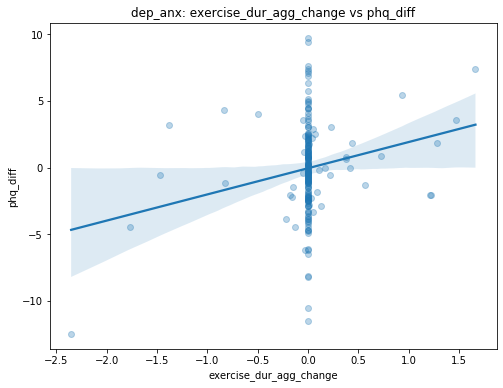

In [224]:
ls_utils.plot_cluster_scatter('exercise_dur_agg_change', 'phq_diff', phq_corr, 'dep_anx', (8,6))

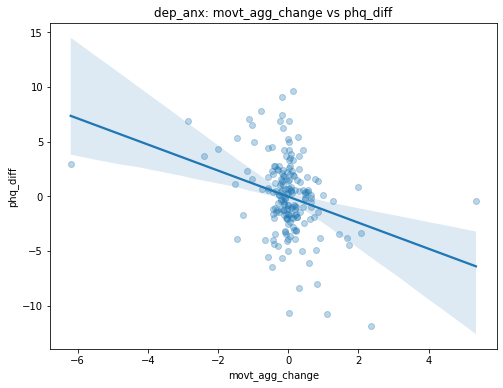

In [225]:
ls_utils.plot_cluster_scatter('movt_agg_change', 'phq_diff', phq_corr, 'dep_anx', (8,6))

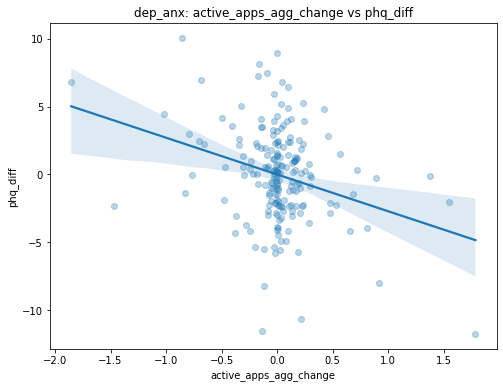

In [226]:
ls_utils.plot_cluster_scatter('active_apps_agg_change', 'phq_diff', phq_corr, 'dep_anx', (8,6))

# Reverse PHQ

## Full population

In [227]:
ls_utils.display_all_corr(rev_phq_corr, agg_cols_change, 'phq_diff', method='pearson')
ls_utils.display_all_corr(rev_phq_corr, agg_cols_change, 'phq_diff', method='spearman');

,X,Y,n,r,p-unc,p-corr,p-adjust
0,active_apps_agg_change,phq_diff,1079,-0.001406,0.9632,0.9632,fdr_bh
1,passive_apps_agg_change,phq_diff,1079,-0.059083,0.0524*,0.1975,fdr_bh
2,social_apps_agg_change,phq_diff,1079,-0.017711,0.5611,0.8979,fdr_bh
3,work_dur_agg_change,phq_diff,1078,-0.016050,0.5986,0.8979,fdr_bh
4,home_dur_agg_change,phq_diff,1078,0.020765,0.4958,0.8979,fdr_bh
5,religion_dur_agg_change,phq_diff,1078,-0.078291,0.0101*,0.1519,fdr_bh
6,exercise_dur_agg_change,phq_diff,1078,-0.069362,0.0228*,0.1707,fdr_bh
7,shopping_dur_agg_change,phq_diff,1078,-0.010710,0.7254,0.9068,fdr_bh
8,other_dur_agg_change,phq_diff,1078,-0.033226,0.2757,0.8272,fdr_bh
9,social_dur_agg_change,phq_diff,1078,-0.027353,0.3696,0.8979,fdr_bh


,X,Y,n,r,p-unc,p-corr,p-adjust
0,active_apps_agg_change,phq_diff,1079,-0.002636,0.9311,0.9633,fdr_bh
1,passive_apps_agg_change,phq_diff,1079,-0.043225,0.1559,0.9633,fdr_bh
2,social_apps_agg_change,phq_diff,1079,-0.014825,0.6267,0.9633,fdr_bh
3,work_dur_agg_change,phq_diff,1078,-0.024208,0.4272,0.9633,fdr_bh
4,home_dur_agg_change,phq_diff,1078,-0.005748,0.8505,0.9633,fdr_bh
5,religion_dur_agg_change,phq_diff,1078,-0.061687,0.0429*,0.6431,fdr_bh
6,exercise_dur_agg_change,phq_diff,1078,-0.008203,0.7879,0.9633,fdr_bh
7,shopping_dur_agg_change,phq_diff,1078,0.015273,0.6164,0.9633,fdr_bh
8,other_dur_agg_change,phq_diff,1078,-0.007773,0.7988,0.9633,fdr_bh
9,social_dur_agg_change,phq_diff,1078,-0.031258,0.3052,0.9633,fdr_bh


## no_symp

In [228]:
sel_state_df = rev_phq_corr[rev_phq_corr['baseline_cluster'] == 'no_symp']
ls_utils.display_all_corr(sel_state_df, agg_cols_change, 'phq_diff', method='pearson')
ls_utils.display_all_corr(sel_state_df, agg_cols_change, 'phq_diff', method='spearman');

,X,Y,n,r,p-unc,p-corr,p-adjust
0,active_apps_agg_change,phq_diff,326,-0.085132,0.1250,0.4074,fdr_bh
1,passive_apps_agg_change,phq_diff,326,0.026564,0.6327,0.7404,fdr_bh
2,social_apps_agg_change,phq_diff,326,0.028278,0.6110,0.7404,fdr_bh
3,work_dur_agg_change,phq_diff,325,-0.016825,0.7625,0.7625,fdr_bh
4,home_dur_agg_change,phq_diff,325,0.090426,0.1037,0.4074,fdr_bh
5,religion_dur_agg_change,phq_diff,325,-0.057040,0.3053,0.6444,fdr_bh
6,exercise_dur_agg_change,phq_diff,325,-0.066088,0.2348,0.5870,fdr_bh
7,shopping_dur_agg_change,phq_diff,325,-0.027661,0.6193,0.7404,fdr_bh
8,other_dur_agg_change,phq_diff,325,-0.025912,0.6416,0.7404,fdr_bh
9,social_dur_agg_change,phq_diff,325,-0.019760,0.7227,0.7625,fdr_bh


,X,Y,n,r,p-unc,p-corr,p-adjust
0,active_apps_agg_change,phq_diff,326,-0.073536,0.1854,0.6163,fdr_bh
1,passive_apps_agg_change,phq_diff,326,0.153779,0.0054*,0.0809*,fdr_bh
2,social_apps_agg_change,phq_diff,326,0.075324,0.1749,0.6163,fdr_bh
3,work_dur_agg_change,phq_diff,325,0.004759,0.9319,0.9319,fdr_bh
4,home_dur_agg_change,phq_diff,325,0.056466,0.3102,0.6163,fdr_bh
5,religion_dur_agg_change,phq_diff,325,0.016646,0.7650,0.8196,fdr_bh
6,exercise_dur_agg_change,phq_diff,325,-0.073445,0.1866,0.6163,fdr_bh
7,shopping_dur_agg_change,phq_diff,325,0.045456,0.4141,0.6163,fdr_bh
8,other_dur_agg_change,phq_diff,325,0.047304,0.3953,0.6163,fdr_bh
9,social_dur_agg_change,phq_diff,325,-0.046679,0.4016,0.6163,fdr_bh


## soc_anx

In [229]:
sel_state_df = rev_phq_corr[rev_phq_corr['baseline_cluster'] == 'soc_anx']
ls_utils.display_all_corr(sel_state_df, agg_cols_change, 'phq_diff', method='pearson')
ls_utils.display_all_corr(sel_state_df, agg_cols_change, 'phq_diff', method='spearman');

,X,Y,n,r,p-unc,p-corr,p-adjust
0,active_apps_agg_change,phq_diff,293,0.016912,0.7731,0.8284,fdr_bh
1,passive_apps_agg_change,phq_diff,293,-0.075562,0.1971,0.7154,fdr_bh
2,social_apps_agg_change,phq_diff,293,0.041709,0.4770,0.7154,fdr_bh
3,work_dur_agg_change,phq_diff,293,-0.053025,0.3658,0.7154,fdr_bh
4,home_dur_agg_change,phq_diff,293,-0.003238,0.9560,0.9560,fdr_bh
5,religion_dur_agg_change,phq_diff,293,-0.105049,0.0726*,0.5079,fdr_bh
6,exercise_dur_agg_change,phq_diff,293,-0.126267,0.0307*,0.4607,fdr_bh
7,shopping_dur_agg_change,phq_diff,293,0.063418,0.2793,0.7154,fdr_bh
8,other_dur_agg_change,phq_diff,293,0.044793,0.4450,0.7154,fdr_bh
9,social_dur_agg_change,phq_diff,293,0.022487,0.7015,0.8094,fdr_bh


,X,Y,n,r,p-unc,p-corr,p-adjust
0,active_apps_agg_change,phq_diff,293,-0.019497,0.7396,0.9181,fdr_bh
1,passive_apps_agg_change,phq_diff,293,-0.084532,0.1489,0.6246,fdr_bh
2,social_apps_agg_change,phq_diff,293,0.007723,0.8953,0.9181,fdr_bh
3,work_dur_agg_change,phq_diff,293,-0.024164,0.6804,0.9181,fdr_bh
4,home_dur_agg_change,phq_diff,293,-0.042453,0.4691,0.9181,fdr_bh
5,religion_dur_agg_change,phq_diff,293,-0.037698,0.5204,0.9181,fdr_bh
6,exercise_dur_agg_change,phq_diff,293,0.017652,0.7635,0.9181,fdr_bh
7,shopping_dur_agg_change,phq_diff,293,0.117183,0.0451*,0.6246,fdr_bh
8,other_dur_agg_change,phq_diff,293,0.024830,0.6721,0.9181,fdr_bh
9,social_dur_agg_change,phq_diff,293,0.031051,0.5966,0.9181,fdr_bh


## gen_anx

In [230]:
sel_state_df = rev_phq_corr[rev_phq_corr['baseline_cluster'] == 'gen_anx']
ls_utils.display_all_corr(sel_state_df, agg_cols_change, 'phq_diff', method='pearson')
ls_utils.display_all_corr(sel_state_df, agg_cols_change, 'phq_diff', method='spearman');

,X,Y,n,r,p-unc,p-corr,p-adjust
0,active_apps_agg_change,phq_diff,268,0.002360,0.9693,0.9757,fdr_bh
1,passive_apps_agg_change,phq_diff,268,-0.113322,0.0640*,0.2398,fdr_bh
2,social_apps_agg_change,phq_diff,268,-0.024520,0.6895,0.8618,fdr_bh
3,work_dur_agg_change,phq_diff,268,-0.030721,0.6166,0.8618,fdr_bh
4,home_dur_agg_change,phq_diff,268,0.009179,0.8811,0.9757,fdr_bh
5,religion_dur_agg_change,phq_diff,268,-0.113653,0.0632*,0.2398,fdr_bh
6,exercise_dur_agg_change,phq_diff,268,-0.026473,0.6662,0.8618,fdr_bh
7,shopping_dur_agg_change,phq_diff,268,-0.045085,0.4623,0.8618,fdr_bh
8,other_dur_agg_change,phq_diff,268,-0.145669,0.0170*,0.1276,fdr_bh
9,social_dur_agg_change,phq_diff,268,-0.026481,0.6661,0.8618,fdr_bh


,X,Y,n,r,p-unc,p-corr,p-adjust
0,active_apps_agg_change,phq_diff,268,0.032004,0.6019,0.7524,fdr_bh
1,passive_apps_agg_change,phq_diff,268,-0.081671,0.1825,0.6579,fdr_bh
2,social_apps_agg_change,phq_diff,268,-0.036358,0.5534,0.7524,fdr_bh
3,work_dur_agg_change,phq_diff,268,-0.066142,0.2806,0.6579,fdr_bh
4,home_dur_agg_change,phq_diff,268,-0.002745,0.9643,0.9643,fdr_bh
5,religion_dur_agg_change,phq_diff,268,-0.166309,0.0064*,0.0953*,fdr_bh
6,exercise_dur_agg_change,phq_diff,268,0.006670,0.9135,0.9643,fdr_bh
7,shopping_dur_agg_change,phq_diff,268,-0.068820,0.2616,0.6579,fdr_bh
8,other_dur_agg_change,phq_diff,268,-0.073779,0.2287,0.6579,fdr_bh
9,social_dur_agg_change,phq_diff,268,-0.033511,0.5849,0.7524,fdr_bh


## dep_anx

In [231]:
sel_state_df = rev_phq_corr[rev_phq_corr['baseline_cluster'] == 'dep_anx']
ls_utils.display_all_corr(sel_state_df, agg_cols_change, 'phq_diff', method='pearson')
ls_utils.display_all_corr(sel_state_df, agg_cols_change, 'phq_diff', method='spearman');

,X,Y,n,r,p-unc,p-corr,p-adjust
0,active_apps_agg_change,phq_diff,192,0.101817,0.1599,0.6303,fdr_bh
1,passive_apps_agg_change,phq_diff,192,-0.101753,0.1602,0.6303,fdr_bh
2,social_apps_agg_change,phq_diff,192,-0.099304,0.1706,0.6303,fdr_bh
3,work_dur_agg_change,phq_diff,192,0.082443,0.2556,0.6390,fdr_bh
4,home_dur_agg_change,phq_diff,192,-0.015045,0.8359,0.8693,fdr_bh
5,religion_dur_agg_change,phq_diff,192,0.011957,0.8693,0.8693,fdr_bh
6,exercise_dur_agg_change,phq_diff,192,-0.034646,0.6333,0.8693,fdr_bh
7,shopping_dur_agg_change,phq_diff,192,-0.071357,0.3253,0.6972,fdr_bh
8,other_dur_agg_change,phq_diff,192,0.015588,0.8301,0.8693,fdr_bh
9,social_dur_agg_change,phq_diff,192,-0.090852,0.2101,0.6303,fdr_bh


,X,Y,n,r,p-unc,p-corr,p-adjust
0,active_apps_agg_change,phq_diff,192,0.091097,0.2089,0.4923,fdr_bh
1,passive_apps_agg_change,phq_diff,192,-0.148222,0.0402*,0.3014,fdr_bh
2,social_apps_agg_change,phq_diff,192,-0.114855,0.1127,0.4923,fdr_bh
3,work_dur_agg_change,phq_diff,192,-0.012740,0.8608,0.8659,fdr_bh
4,home_dur_agg_change,phq_diff,192,-0.035150,0.6284,0.8659,fdr_bh
5,religion_dur_agg_change,phq_diff,192,-0.023118,0.7503,0.8659,fdr_bh
6,exercise_dur_agg_change,phq_diff,192,0.091313,0.2078,0.4923,fdr_bh
7,shopping_dur_agg_change,phq_diff,192,-0.025915,0.7212,0.8659,fdr_bh
8,other_dur_agg_change,phq_diff,192,-0.020492,0.7779,0.8659,fdr_bh
9,social_dur_agg_change,phq_diff,192,-0.070370,0.3321,0.6227,fdr_bh


# Summary Tables of Significant Correlations

## SPIN

In [232]:
ls_utils.build_corr_table(gad_spin_corr, 'passive_apps_agg_change', agg_cols_change, 'spin_diff', 'passive app change to SPIN change')

,group,n,r,p-corr,p-adjust
0,all,1028,0.043183,0.624397,fdr_bh
1,no_symp,325,0.040155,0.964106,fdr_bh
2,soc_anx,267,0.038612,0.722548,fdr_bh
3,gen_anx,252,0.006098,0.923263,fdr_bh
4,dep_anx,184,0.137741,0.933624,fdr_bh


In [233]:
ls_utils.build_corr_table(rev_gad_spin_corr, 'passive_apps_agg_change', agg_cols_change, 'spin_diff', 'SPIN change to passive app change')

,group,n,r,p-corr,p-adjust
0,all,1023,-0.008104,0.914857,fdr_bh
1,no_symp,325,0.027856,0.834020,fdr_bh
2,soc_anx,266,-0.126167,0.298188,fdr_bh
3,gen_anx,251,0.036672,0.701366,fdr_bh
4,dep_anx,181,0.089206,0.937408,fdr_bh


## GAD

In [264]:
ls_utils.build_corr_table(gad_spin_corr, 'active_apps_agg_change', agg_cols_change, 'gad_diff', 'active apps change to GAD change', method='spearman')

,group,n,r,p-corr,p-adjust
0,all,1029,0.082725,0.072043,fdr_bh
1,no_symp,325,0.003022,0.956715,fdr_bh
2,soc_anx,267,0.189139,0.027491,fdr_bh
3,gen_anx,253,0.137795,0.426364,fdr_bh
4,dep_anx,184,-0.014492,0.924672,fdr_bh


In [263]:
ls_utils.build_corr_table(rev_gad_spin_corr, 'active_apps_agg_change', agg_cols_change, 'gad_diff', 'GAD change to active apps change', method='spearman')

,group,n,r,p-corr,p-adjust
0,all,1023,0.021974,0.656158,fdr_bh
1,no_symp,325,0.070313,0.735433,fdr_bh
2,soc_anx,266,-0.054045,0.456119,fdr_bh
3,gen_anx,251,0.031845,0.839425,fdr_bh
4,dep_anx,181,0.044220,0.949977,fdr_bh


## PHQ

In [261]:
ls_utils.build_corr_table(phq_corr, 'movt_distance_agg_change', agg_cols_change, 'phq_diff', 'movt distance change to PHQ change')

,group,n,r,p-corr,p-adjust
0,all,1073,-0.117765,0.000828,fdr_bh
1,no_symp,325,-0.135156,0.138941,fdr_bh
2,soc_anx,292,-0.080654,0.279309,fdr_bh
3,gen_anx,268,-0.203915,0.011777,fdr_bh
4,dep_anx,188,-0.182752,0.030163,fdr_bh


In [262]:
ls_utils.build_corr_table(rev_phq_corr, 'movt_distance_agg_change', agg_cols_change, 'phq_diff', 'PHQ change to movt distance change')

,group,n,r,p-corr,p-adjust
0,all,1072,0.012797,0.906759,fdr_bh
1,no_symp,325,0.082916,0.407415,fdr_bh
2,soc_anx,291,-0.043415,0.715439,fdr_bh
3,gen_anx,266,-0.148812,0.127639,fdr_bh
4,dep_anx,190,0.031352,0.869253,fdr_bh


# Change over Time Periods Analysis

## Functions

In [238]:
def plot_over_time(cols, df, title, study_wks=[4,7,10,13,16], figsize=(8,6)):
    _, ax = plt.subplots(figsize=figsize)
    for col in cols:
        cal_pairs = df[df['X'] == col]
        errs = np.concatenate(cal_pairs['CI95%'].values).reshape(len(cal_pairs['r'].values),2).T
        #print(len(cal_pairs['r'].values))
        errs = errs - cal_pairs['r'].values
        errs = np.abs(errs)
        #errs = np.flip(errs,0)
        plt.errorbar(x=cal_pairs['idx'], y=cal_pairs['r'], yerr=errs, label=col, capsize=5)
    

    plt.axhline(y=0, ls='--')
    plt.xlabel("study_wk")
    plt.xticks(study_wks)
    plt.title(title)
    plt.legend()
    
    return plt    

In [239]:
def build_time_corr_df(seq_df, target, feat_cols, study_wks=[4,7,10,13,16]):
    pair_df = pd.DataFrame()
    for idx in study_wks:
        sel_df = seq_df[seq_df['study_wk'] == idx]
        #sel_df = sel_df.dropna(subset=['date'])
        sel_df = sel_df[[target] + feat_cols]
        df = pg.pairwise_corr(sel_df, columns=[feat_cols, [target]], padjust="fdr_bh")
        df['idx'] = idx
        pair_df = pair_df.append(df)
        
    return pair_df

## PHQ

In [247]:
pop_df = build_time_corr_df(phq_corr, 'phq_diff', agg_cols_change)

In [248]:
dep_anx_df = build_time_corr_df(phq_corr[phq_corr['baseline_cluster'] == 'dep_anx'], 'phq_diff', agg_cols_change)

## GAD

In [249]:
gad_df = build_time_corr_df(gad_spin_corr, 'gad_diff', agg_cols_change, study_wks=[7,10,13,16])

In [250]:
gad_df[gad_df['X'] == 'social_apps_agg_change']

,X,Y,method,tail,n,r,CI95%,r2,adj_r2,z,p-unc,p-corr,p-adjust,BF10,power,idx
2,social_apps_agg_change,gad_diff,pearson,two-sided,256,-0.130980,"[-0.25, -0.01]",0.017156,0.009386,-0.131737,0.036219,0.271644,fdr_bh,0.693,0.555296,7
2,social_apps_agg_change,gad_diff,pearson,two-sided,257,0.047859,"[-0.07, 0.17]",0.002291,-0.005565,0.047896,0.444904,0.682782,fdr_bh,0.104,0.119124,10
2,social_apps_agg_change,gad_diff,pearson,two-sided,258,-0.043195,"[-0.16, 0.08]",0.001866,-0.005963,-0.043222,0.489708,0.911332,fdr_bh,0.099,0.106230,13
2,social_apps_agg_change,gad_diff,pearson,two-sided,258,0.049453,"[-0.07, 0.17]",0.002446,-0.005378,0.049493,0.428970,0.957820,fdr_bh,0.106,0.124237,16


In [251]:
dep_anx_gad_df = build_time_corr_df(gad_spin_corr[gad_spin_corr['baseline_cluster'] == 'dep_anx'], 'gad_diff', agg_cols_change, study_wks=[7,10,13,16])

In [252]:
dep_anx_gad_df[dep_anx_gad_df['X'] == 'social_apps_agg_change']

,X,Y,method,tail,n,r,CI95%,r2,adj_r2,z,p-unc,p-corr,p-adjust,BF10,power,idx
2,social_apps_agg_change,gad_diff,pearson,two-sided,46,-0.336495,"[-0.57, -0.05]",0.113229,0.071984,-0.350135,0.022222,0.166668,fdr_bh,2.317,0.639695,7
2,social_apps_agg_change,gad_diff,pearson,two-sided,46,0.027395,"[-0.27, 0.32]",0.000750,-0.045726,0.027402,0.856585,0.964025,fdr_bh,0.187,0.053433,10
2,social_apps_agg_change,gad_diff,pearson,two-sided,46,-0.316716,"[-0.56, -0.03]",0.100309,0.058463,-0.327992,0.031993,0.284561,fdr_bh,1.708,0.583565,13
2,social_apps_agg_change,gad_diff,pearson,two-sided,46,-0.148349,"[-0.42, 0.15]",0.022007,-0.023481,-0.149452,0.325155,0.661031,fdr_bh,0.294,0.167080,16


## SPIN

In [253]:
spin_df = build_time_corr_df(gad_spin_corr, 'spin_diff', agg_cols_change, study_wks=[7,10,13,16])

In [254]:
spin_df[spin_df['X'] == 'passive_apps_agg_change'][['X', 'Y', 'n', 'r', 'idx', 'p-unc','p-corr', 'p-adjust', 'CI95%']]

,X,Y,n,r,idx,p-unc,p-corr,p-adjust,CI95%
1,passive_apps_agg_change,spin_diff,256,-0.037776,7,0.547392,0.872834,fdr_bh,"[-0.16, 0.09]"
1,passive_apps_agg_change,spin_diff,257,0.082060,10,0.189748,0.687406,fdr_bh,"[-0.04, 0.2]"
1,passive_apps_agg_change,spin_diff,258,0.067549,13,0.279714,0.975776,fdr_bh,"[-0.06, 0.19]"
1,passive_apps_agg_change,spin_diff,257,0.120872,16,0.052943,0.264717,fdr_bh,"[-0.0, 0.24]"


(-0.4, 1)

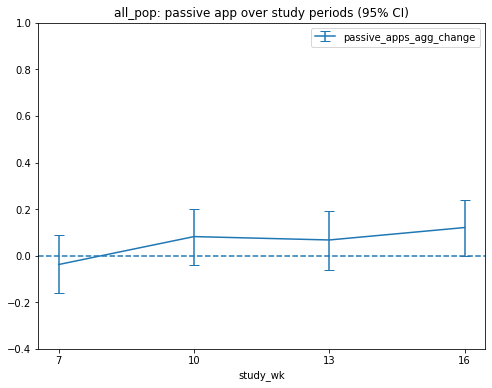

In [255]:
p = plot_over_time(['passive_apps_agg_change'], spin_df, "all_pop: passive app over study periods (95% CI)", study_wks=[7,10,13,16])
p.ylim(-0.4,1)

In [256]:
soc_anx_spin_df = build_time_corr_df(gad_spin_corr[gad_spin_corr['baseline_cluster'] == 'soc_anx'], 'spin_diff', agg_cols_change, study_wks=[7,10,13,16])

In [257]:
soc_anx_spin_df[soc_anx_spin_df['X'] == 'passive_apps_agg_change'][['X', 'Y', 'n', 'r', 'idx', 'p-unc','p-corr', 'p-adjust', 'CI95%']]

,X,Y,n,r,idx,p-unc,p-corr,p-adjust,CI95%
1,passive_apps_agg_change,spin_diff,66,-0.282863,7,0.021374,0.160309,fdr_bh,"[-0.49, -0.04]"
1,passive_apps_agg_change,spin_diff,66,0.232898,10,0.059851,0.511832,fdr_bh,"[-0.01, 0.45]"
1,passive_apps_agg_change,spin_diff,67,0.291428,13,0.016723,0.125423,fdr_bh,"[0.06, 0.5]"
1,passive_apps_agg_change,spin_diff,68,0.299424,16,0.013118,0.196777,fdr_bh,"[0.07, 0.5]"


(-0.4, 1)

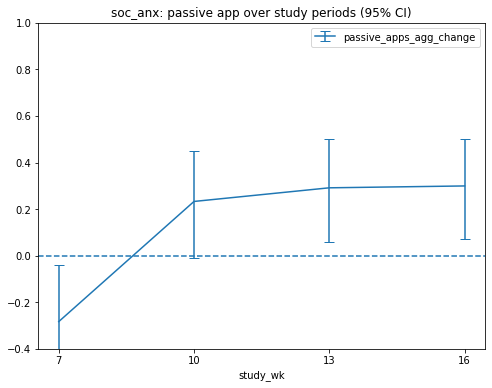

In [258]:
p = plot_over_time(['passive_apps_agg_change'], soc_anx_spin_df, "soc_anx: passive app over study periods (95% CI)", study_wks=[7,10,13,16])
p.ylim(-0.4,1)